In [36]:
# https://wandb.ai/safijari/dqn-tutorial/reports/Deep-Q-Networks-DQN-With-the-Cartpole-Environment--Vmlldzo4MDc2MQ

In [2]:
# data["action_value"] # shape (batch_size, num_actions)
# Get the mean q_value from the batch data["action_value"]
# data["action_value"].mean()

import torch
# Create a toy tensor with shape (10, 2)
tensor = torch.rand(10, 2)

In [3]:
tensor

tensor([[0.4304, 0.3132],
        [0.7245, 0.4431],
        [0.9938, 0.1911],
        [0.6044, 0.1895],
        [0.4958, 0.2732],
        [0.5166, 0.9291],
        [0.2419, 0.7202],
        [0.1368, 0.6574],
        [0.7252, 0.6230],
        [0.1141, 0.6644]])

In [6]:
tensor.mean(-1).mean()

tensor(0.4994)

In [4]:
tensor.mean()

tensor(0.4994)

In [1]:
import torch
import time

from torchrl.envs import GymEnv, StepCounter, TransformedEnv
from tensordict.nn import TensorDictModule as Mod, TensorDictSequential as Seq
from torchrl.modules import EGreedyModule, MLP, QValueModule
from torchrl.collectors import SyncDataCollector
from torchrl.data import LazyTensorStorage, ReplayBuffer
from torch.optim import Adam
from torchrl.objectives import DQNLoss, SoftUpdate
from torchrl._utils import logger as torchrl_logger
from torchrl.record import CSVLogger, VideoRecorder
from torchrl.modules import QValueActor
from torchrl.data import CompositeSpec

torch.manual_seed(0)


In [2]:
from torchrl.envs import (
    CatFrames,
    DoubleToFloat,
    EndOfLifeTransform,
    GrayScale,
    GymEnv,
    NoopResetEnv,
    Resize,
    RewardSum,
    SignTransform,
    StepCounter,
    ToTensorImage,
    TransformedEnv,
    VecNorm,
)

def make_env(env_name="CartPole-v1", frame_skip = 4, 
             device="cpu", seed = 0, is_test=False):

    env = GymEnv(
        env_name,
        frame_skip=frame_skip,
        from_pixels=True,
        pixels_only=False,
        device=device,
    )
    env = TransformedEnv(env)
    # env.append_transform(NoopResetEnv(noops=30, random=True)) # NOTE: Cartpole with no noops will fall into reset in the begining
                                                                # I could use an small noop reset to avoid this, but I think is not necesary
                                                                # in this case. Analyze this later
    if not is_test:
        # env.append_transform(EndOfLifeTransform()) # NOTE: Check my environment is not based on lives (so not important)
        env.append_transform(SignTransform(in_keys=["reward"])) #NOTE: cartpole has no negative rewards
    env.append_transform(ToTensorImage()) 
    env.append_transform(GrayScale())
    env.append_transform(Resize(84, 84))
    env.append_transform(CatFrames(N=4, dim=-3))
    env.append_transform(RewardSum())
    env.append_transform(StepCounter()) # NOTE: Cartpole-v1 has a max of 500 steps
    env.append_transform(DoubleToFloat())
    env.append_transform(VecNorm(in_keys=["pixels"]))
    env.set_seed(seed)

    # NOTE: a rollout will be take a trajectory of frames and group the frames by N=4 sequentially
    # so that the output will be 7x4x84x84 because with a rollout of 10 steps we will have 7 groups of
    # 4 frames each
    return env

In [6]:
env = make_env(env_name="CartPole-v1", 
               frame_skip = 4, 
               device="cpu", #
               seed = 0,  
               is_test=False)

In [8]:
env.available_envs

['Acrobot-v1',
 'Ant-v2',
 'Ant-v3',
 'Ant-v4',
 'BipedalWalker-v3',
 'BipedalWalkerHardcore-v3',
 'Blackjack-v1',
 'CarRacing-v2',
 'CartPole-v0',
 'CartPole-v1',
 'CliffWalking-v0',
 'FrozenLake-v1',
 'FrozenLake8x8-v1',
 'GymV21Environment-v0',
 'GymV26Environment-v0',
 'HalfCheetah-v2',
 'HalfCheetah-v3',
 'HalfCheetah-v4',
 'Hopper-v2',
 'Hopper-v3',
 'Hopper-v4',
 'Humanoid-v2',
 'Humanoid-v3',
 'Humanoid-v4',
 'HumanoidStandup-v2',
 'HumanoidStandup-v4',
 'InvertedDoublePendulum-v2',
 'InvertedDoublePendulum-v4',
 'InvertedPendulum-v2',
 'InvertedPendulum-v4',
 'LunarLander-v2',
 'LunarLanderContinuous-v2',
 'MountainCar-v0',
 'MountainCarContinuous-v0',
 'Pendulum-v1',
 'Pusher-v2',
 'Pusher-v4',
 'Reacher-v2',
 'Reacher-v4',
 'Swimmer-v2',
 'Swimmer-v3',
 'Swimmer-v4',
 'Taxi-v3',
 'Walker2d-v2',
 'Walker2d-v3',
 'Walker2d-v4',
 'phys2d/CartPole-v0',
 'phys2d/CartPole-v1',
 'phys2d/Pendulum-v0',
 'tabular/Blackjack-v0',
 'tabular/CliffWalking-v0']

In [1]:
import gymnasium as gym
import numpy as np
env = gym.make("MiniGrid-Empty-5x5-v0") #, render_mode="human")
observation, info = env.reset(seed=42)
for _ in range(10):
   # Random action
   action = np.random.randint(env.action_space.n)
   observation, reward, terminated, truncated, info = env.step(action)

   print(f"Action: {action}, Reward: {reward}")
   print(f"Observation shape: {observation['image'].shape}")
   print(observation.keys())

   if terminated or truncated:
      observation, info = env.reset()
env.close()

pygame 2.6.0 (SDL 2.28.4, Python 3.11.9)
Hello from the pygame community. https://www.pygame.org/contribute.html
Action: 0, Reward: 0
Observation shape: (7, 7, 3)
dict_keys(['image', 'direction', 'mission'])
Action: 1, Reward: 0
Observation shape: (7, 7, 3)
dict_keys(['image', 'direction', 'mission'])
Action: 1, Reward: 0
Observation shape: (7, 7, 3)
dict_keys(['image', 'direction', 'mission'])
Action: 2, Reward: 0
Observation shape: (7, 7, 3)
dict_keys(['image', 'direction', 'mission'])
Action: 6, Reward: 0
Observation shape: (7, 7, 3)
dict_keys(['image', 'direction', 'mission'])
Action: 0, Reward: 0
Observation shape: (7, 7, 3)
dict_keys(['image', 'direction', 'mission'])
Action: 4, Reward: 0
Observation shape: (7, 7, 3)
dict_keys(['image', 'direction', 'mission'])
Action: 0, Reward: 0
Observation shape: (7, 7, 3)
dict_keys(['image', 'direction', 'mission'])
Action: 5, Reward: 0
Observation shape: (7, 7, 3)
dict_keys(['image', 'direction', 'mission'])
Action: 4, Reward: 0
Observation

In [4]:
import gymnasium as gym
import numpy as np

# Create the environment
env = gym.make("MiniGrid-Empty-5x5-v0") #, render_mode="human")

# Reset the environment
observation, info = env.reset(seed=42)

# Print action space details
print("Action Space:", env.action_space)
print("Action Space Type:", type(env.action_space))

# Print observation space details
print("Observation Space:", env.observation_space)
print("Observation Space Type:", type(env.observation_space))

# Print more detailed information if it's a Box or Discrete space
if isinstance(env.action_space, gym.spaces.Discrete):
    print("Number of actions:", env.action_space.n)

if isinstance(env.observation_space, gym.spaces.Box):
    print("Observation Space Shape:", env.observation_space.shape)
    print("Observation Space High:", env.observation_space.high)
    print("Observation Space Low:", env.observation_space.low)

# Step through the environment
for _ in range(10):
    # Random action
    action = np.random.randint(env.action_space.n)
    observation, reward, terminated, truncated, info = env.step(action)

    print(f"Action: {action}, Reward: {reward}")
    print(f"Observation shape: {observation['image'].shape}")
    print("Observation keys:", observation.keys())
    print("Mission:", observation['mission'])

    if terminated or truncated:
        observation, info = env.reset()

# Close the environment
env.close()


Action Space: Discrete(7)
Action Space Type: <class 'gymnasium.spaces.discrete.Discrete'>
Observation Space: Dict('direction': Discrete(4), 'image': Box(0, 255, (7, 7, 3), uint8), 'mission': MissionSpace(<function EmptyEnv._gen_mission at 0x7f9da0186980>, None))
Observation Space Type: <class 'gymnasium.spaces.dict.Dict'>
Number of actions: 7
Action: 2, Reward: 0
Observation shape: (7, 7, 3)
Observation keys: dict_keys(['image', 'direction', 'mission'])
Mission: get to the green goal square
Action: 6, Reward: 0
Observation shape: (7, 7, 3)
Observation keys: dict_keys(['image', 'direction', 'mission'])
Mission: get to the green goal square
Action: 6, Reward: 0
Observation shape: (7, 7, 3)
Observation keys: dict_keys(['image', 'direction', 'mission'])
Mission: get to the green goal square
Action: 0, Reward: 0
Observation shape: (7, 7, 3)
Observation keys: dict_keys(['image', 'direction', 'mission'])
Mission: get to the green goal square
Action: 6, Reward: 0
Observation shape: (7, 7, 3)
O

In [7]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from PIL import Image, ImageDraw

class SimpleGridEnv(gym.Env):
    def __init__(self, grid_size=5):
        super(SimpleGridEnv, self).__init__()
        self.grid_size = grid_size
        self.action_space = spaces.Discrete(4)  # 4 actions: left, right, up, down
        self.observation_space = spaces.Box(low=0, high=grid_size-1, shape=(2,), dtype=np.int32)
        self.state = None
        self.goal = np.array([grid_size-1, grid_size-1])  # Goal position
    
    def reset(self):
        self.state = np.array([0, 0])  # Starting position
        return self.state
    
    def step(self, action):
        if action == 0:   # Left
            self.state[1] = max(0, self.state[1] - 1)
        elif action == 1: # Right
            self.state[1] = min(self.grid_size - 1, self.state[1] + 1)
        elif action == 2: # Up
            self.state[0] = max(0, self.state[0] - 1)
        elif action == 3: # Down
            self.state[0] = min(self.grid_size - 1, self.state[0] + 1)
        
        done = np.array_equal(self.state, self.goal)
        reward = 1 if done else -0.1  # Reward for reaching the goal
        
        return self.state, reward, done, {}
    
    def render(self, mode='human'):
        cell_size = 84 // self.grid_size
        img = Image.new('RGB', (84, 84), color='white')
        draw = ImageDraw.Draw(img)
        
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                top_left = (j * cell_size, i * cell_size)
                bottom_right = ((j + 1) * cell_size, (i + 1) * cell_size)
                draw.rectangle([top_left, bottom_right], outline='black')
        
        # Draw agent
        agent_top_left = (self.state[1] * cell_size, self.state[0] * cell_size)
        agent_bottom_right = ((self.state[1] + 1) * cell_size, (self.state[0] + 1) * cell_size)
        draw.rectangle([agent_top_left, agent_bottom_right], fill='blue')
        
        # Draw goal
        goal_top_left = (self.goal[1] * cell_size, self.goal[0] * cell_size)
        goal_bottom_right = ((self.goal[1] + 1) * cell_size, (self.goal[0] + 1) * cell_size)
        draw.rectangle([goal_top_left, goal_bottom_right], fill='green')
        
        if mode == 'human':
            img.show()
        elif mode == 'rgb_array':
            return np.array(img)

# Example usage
env = SimpleGridEnv(grid_size=5)
observation = env.reset()
env.render(mode='human')

for _ in range(10):
    action = env.action_space.sample()  # Random action
    observation, reward, done, info = env.step(action)
    print(observation.shape)
    # env.render(mode='human')
    if done:
        print("Goal reached!")
        break


(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)


display display: Unable to load font (-*-helvetica-medium-r-normal--12-*-*-*-*-*-iso8859-1) [Resource temporarily unavailable].


In [8]:
import gymnasium as gym

# Create the CartPole environment
env = gym.make("CartPole-v1")

# Print action space details
print("Action Space:", env.action_space)
print("Action Space Type:", type(env.action_space))

# Print observation space details
print("Observation Space:", env.observation_space)
print("Observation Space Type:", type(env.observation_space))

# Print more detailed information if it's a Box or Discrete space
if isinstance(env.action_space, gym.spaces.Discrete):
    print("Number of actions:", env.action_space.n)

if isinstance(env.observation_space, gym.spaces.Box):
    print("Observation Space Shape:", env.observation_space.shape)
    print("Observation Space High:", env.observation_space.high)
    print("Observation Space Low:", env.observation_space.low)


Action Space: Discrete(2)
Action Space Type: <class 'gymnasium.spaces.discrete.Discrete'>
Observation Space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Observation Space Type: <class 'gymnasium.spaces.box.Box'>
Number of actions: 2
Observation Space Shape: (4,)
Observation Space High: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Observation Space Low: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


(84, 84, 3)


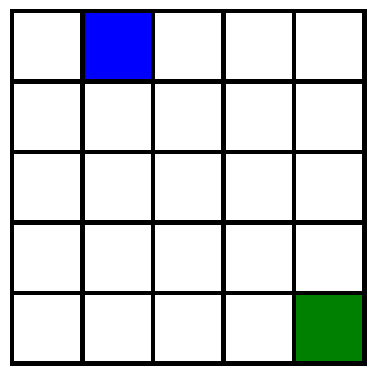

(84, 84, 3)


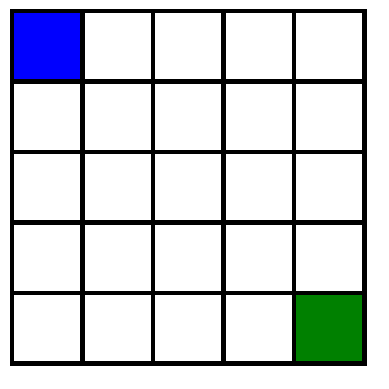

(84, 84, 3)


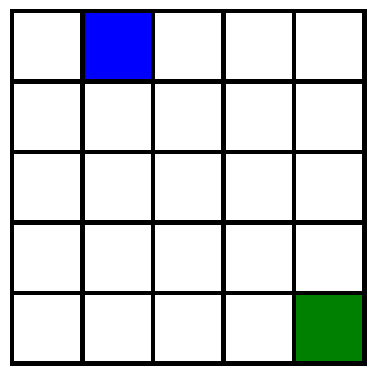

(84, 84, 3)


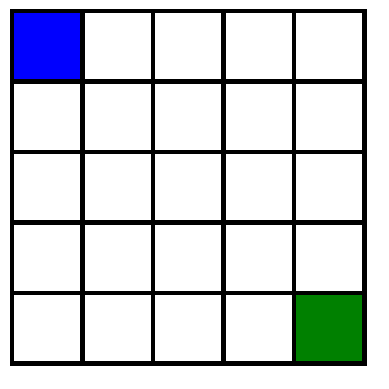

(84, 84, 3)


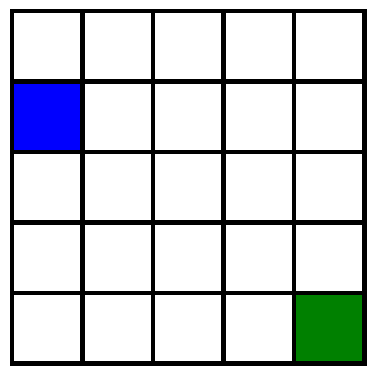

(84, 84, 3)


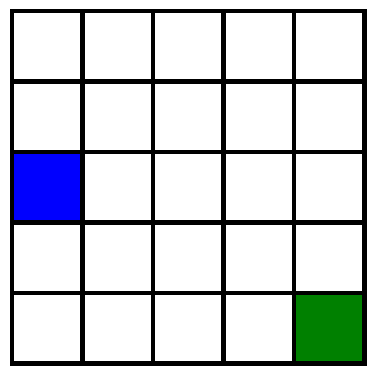

(84, 84, 3)


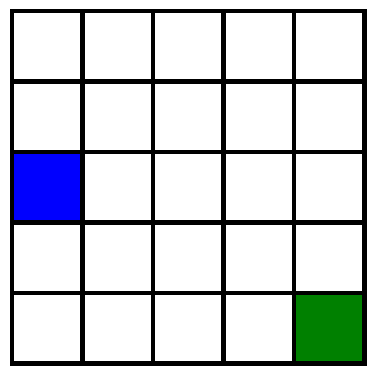

(84, 84, 3)


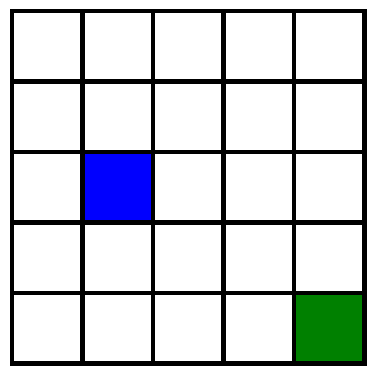

(84, 84, 3)


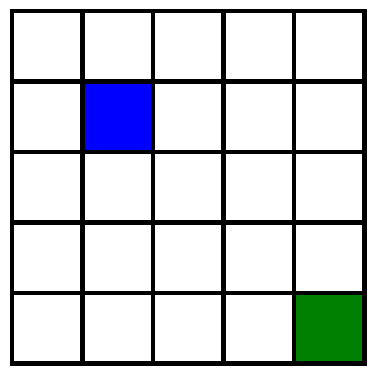

(84, 84, 3)


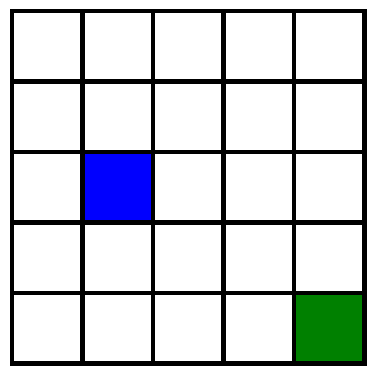

In [8]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt


class SimpleGridEnv(gym.Env):
    def __init__(self, grid_size=5, render_mode = None):
        super(SimpleGridEnv, self).__init__()
        self.render_mode = render_mode
        self.grid_size = grid_size
        self.action_space = spaces.Discrete(4)  # 4 actions: left, right, up, down
        self.observation_space = spaces.Box(low=0, high=grid_size-1, shape=(2,), dtype=np.int32)
        self.state = None
        self.goal = np.array([grid_size-1, grid_size-1])  # Goal position
    
    def reset(self):
        self.state = np.array([0, 0])  # Starting position
        return self.state
    
    def step(self, action):
        if action == 0:   # Left
            self.state[1] = max(0, self.state[1] - 1)
        elif action == 1: # Right
            self.state[1] = min(self.grid_size - 1, self.state[1] + 1)
        elif action == 2: # Up
            self.state[0] = max(0, self.state[0] - 1)
        elif action == 3: # Down
            self.state[0] = min(self.grid_size - 1, self.state[0] + 1)
        
        done = np.array_equal(self.state, self.goal)
        reward = 1 if done else -0.1  # Reward for reaching the goal
        
        return self.state, reward, done, {}
    
    def render(self, mode='human'):
        cell_size = 84 // self.grid_size
        img = Image.new('RGB', (84, 84), color='white')
        draw = ImageDraw.Draw(img)
        
        # Draw agent
        agent_top_left = (self.state[1] * cell_size, self.state[0] * cell_size)
        agent_bottom_right = ((self.state[1] + 1) * cell_size, (self.state[0] + 1) * cell_size)
        draw.rectangle([agent_top_left, agent_bottom_right], fill='blue')
        
        # Draw goal
        goal_top_left = (self.goal[1] * cell_size, self.goal[0] * cell_size)
        goal_bottom_right = ((self.goal[1] + 1) * cell_size, (self.goal[0] + 1) * cell_size)
        draw.rectangle([goal_top_left, goal_bottom_right], fill='green')

        for i in range(self.grid_size):
            for j in range(self.grid_size):
                top_left = (j * cell_size, i * cell_size)
                bottom_right = ((j + 1) * cell_size, (i + 1) * cell_size)
                draw.rectangle([top_left, bottom_right], outline='black')
        
        if self.render_mode == 'human':
            img.show()
        elif self.render_mode == 'rgb_array':
            return np.array(img)

# Example usage
env = SimpleGridEnv(grid_size=5, render_mode='rgb_array')
observation = env.reset()

for _ in range(10):
    action = env.action_space.sample()  # Random action
    observation, reward, done, info = env.step(action)

    pixels = env.render()

    print(pixels.shape)

    # Convert numpy array to PIL image and resize to 84x84 pixels
    img = Image.fromarray(pixels)

    # Display the resized image using matplotlib
    plt.imshow(img)
    plt.axis('off')  # Hide axis
    plt.show()

    # Close the environment
    if done:
        print("Goal reached!")
        break


In [30]:
with open("grid.txt", 'r') as file:
    lines = file.readlines()
    print(len(lines[0].split()))
    print(len(lines))

np.array([line.split() for line in lines])

5
7


array([['x', 'x', 'x', 'x', 'x'],
       ['x', '.', '.', 'G', 'x'],
       ['x', '.', '.', '.', 'x'],
       ['x', 'x', '.', 'x', 'x'],
       ['x', '.', '.', 'G', 'x'],
       ['x', '.', '.', '.', 'x'],
       ['x', 'x', 'x', 'x', 'x']], dtype='<U1')

In [26]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

class SimpleGridEnv(gym.Env):
    def __init__(self, render_mode=None, grid_file=None):
        super(SimpleGridEnv, self).__init__()
        self.render_mode = render_mode
        self.goal_positions = []
        self.load_grid_from_file(grid_file)
        self.action_space = spaces.Discrete(4)  # 4 actions: left, right, up, down
        self.observation_space = spaces.Box(low=0, high=self.grid_size-1, shape=(2,), dtype=np.int32)
        self.state = None
        
        

    def load_grid_from_file(self, file_path):
        with open(file_path, 'r') as file:
            lines = file.readlines()
            self.height = len(lines)
            self.width = len(lines[0].split())
            self.grid_size = max(self.height, self.width)

            if self.height != self.width:
                print("Warning: The grid is not square. Padding with 'x' to make it square.")
            self.grid = np.array([line.split() for line in lines])

        def make_square(grid):
            # Get the dimensions of the grid
            rows, cols = grid.shape
            
            # Determine the size of the square matrix
            size = max(rows, cols)
            
            # Calculate padding for rows and columns
            row_padding_top = (size - rows) // 2
            row_padding_bottom = size - rows - row_padding_top
            col_padding_left = (size - cols) // 2
            col_padding_right = size - cols - col_padding_left
            
            # Pad the grid with 'x' to make it square
            square_grid = np.pad(grid, 
                                pad_width=((row_padding_top, row_padding_bottom), (col_padding_left, col_padding_right)),
                                mode='constant', 
                                constant_values='x')
            
            return square_grid
           
        self.grid = make_square(self.grid)

            # Add walls in the width or height to make the grid square, but keep it centered

        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if self.grid[i, j] == 'G':
                    self.goal_positions.append((i, j))
        


    def reset(self, seed=None, return_info=False, options=None):
        super().reset(seed=seed)
        # Find a starting position randomly among the '.' positions
        start_positions = np.argwhere(self.grid == '.')
        start_idx = np.random.choice(len(start_positions))
        self.state = start_positions[start_idx]
        if return_info:
            return self.state, {}
        else:
            return self.state

    def step(self, action):
        if action == 0:   # Left
            self.state[1] = max(0, self.state[1] - 1)
        elif action == 1: # Right
            self.state[1] = min(self.grid_size - 1, self.state[1] + 1)
        elif action == 2: # Up
            self.state[0] = max(0, self.state[0] - 1)
        elif action == 3: # Down
            self.state[0] = min(self.grid_size - 1, self.state[0] + 1)
        
        # Check for wall collisions
        if self.grid[self.state[0], self.state[1]] == 'x':
            if action == 0:   # Move back to the right
                self.state[1] += 1
            elif action == 1: # Move back to the left
                self.state[1] -= 1
            elif action == 2: # Move back down
                self.state[0] += 1
            elif action == 3: # Move back up
                self.state[0] -= 1
        
        done = tuple(self.state) in self.goal_positions
        reward = 1 if done else -0.1  # Reward for reaching the goal
        
        return self.state, reward, done, False, {}

    def render(self, mode='human'):
        cell_size = 84 // self.grid_size
        img = Image.new('RGB', (84, 84), color='white')
        draw = ImageDraw.Draw(img)
        
        # Draw grid
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                top_left = (j * cell_size, i * cell_size)
                bottom_right = ((j + 1) * cell_size, (i + 1) * cell_size)
                if self.grid[i, j] == 'x':
                    draw.rectangle([top_left, bottom_right], fill='#646464ff', outline='#646464ff')
                elif self.grid[i, j] == 'G':
                    draw.rectangle([top_left, bottom_right], fill='#00FF00', outline='#646464ff')
                else:
                    draw.rectangle([top_left, bottom_right], fill='#000000', outline='#646464ff')
        
        # Draw agent
        agent_top_left = (self.state[1] * cell_size, self.state[0] * cell_size)
        agent_bottom_right = ((self.state[1] + 1) * cell_size, (self.state[0] + 1) * cell_size)
        draw.rectangle([agent_top_left, agent_bottom_right], fill='#0000FF', outline='#646464ff')

        if self.render_mode == 'human':
            img.show()
        elif self.render_mode == 'rgb_array':
            return np.array(img)

# Example usage
grid_file_content = """\
x x x x x
x . . G x
x . . . x
x x . x x
x . . G x
x . . . x
x x x x x
"""

# with open('grid.txt', 'w') as file:
#     file.write(grid_file_content)

env = SimpleGridEnv(grid_file='custom_envs/grid_envs/grid_world2.txt', render_mode='rgb_array')
observation = env.reset()

for _ in range(3):
    action = env.action_space.sample()  # Random action
    observation, reward, done, truncated, info = env.step(action)

    print(observation)

    pixels = env.render()

    print(pixels.shape)

    # Convert numpy array to PIL image and resize to 84x84 pixels
    img = Image.fromarray(pixels)

    # Display the resized image using matplotlib
    plt.imshow(img)
    plt.axis('off')  # Hide axis
    plt.show()

    # Convert to gray scale and plot
    # gray_img = img.convert('L')
    # plt.imshow(gray_img, cmap='gray')
    # plt.axis('off')  # Hide axis
    # plt.show()

    if done:
        print("Goal reached!")
        break

# Close the environment
env.close()


/home/zosov/anaconda3/envs/final-project/lib/python3.11/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment SimpleGridEnv-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/zosov/anaconda3/envs/final-project/lib/python3.11/site-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 it will default to `None`. With a device of None, no device casting is performed and the resulting tensordicts are deviceless. Please set your device accordingly.
  warnings.warn(
/home/zosov/anaconda3/envs/final-project/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:189: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  lo

RuntimeError: Shape mismatch: the value has shape torch.Size([]) which is incompatible with the spec shape torch.Size([2]).

In [123]:
import gymnasium as gym
from gymnasium import spaces
import pygame
import numpy as np


class GridWorldEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None, grid_file = None):

        # Load from a file
        if grid_file is None:
            raise ValueError("You must provide a grid file. As an example, you can use the grid.txt file.")
        
        self._grid = self.load_grid_from_file(grid_file)

        self.size = self._grid.shape[0] # if self._grid else size  # The size of the square grid
        self.window_size = 512  # The size of the PyGame window

        # Set walls and target
        self._set_components()

        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`}^2, i.e. MultiDiscrete([size, size]).
        # self.observation_space = spaces.Dict(
        #     {
        #         "agent": spaces.Box(0, self.size - 1, shape=(2,), dtype=int),
        #         "target": spaces.Box(0, self.size - 1, shape=(2,), dtype=int),
        #     }
        # )
        self.observation_space = spaces.Box(low=0, high=self.size-1, shape=(2,), dtype=np.int32)


        # We have 4 actions, corresponding to "down", "right", "up" and "left".
        # Action 0: Down
        # Action 1: Right
        # Action 2: Up
        # Action 3: Left
        self.action_space = spaces.Discrete(4)

        """
        The following dictionary maps abstract actions from `self.action_space` to 
        the direction we will walk in if that action is taken.
        I.e. 0 corresponds to "right", 1 to "up" etc.
        """
        self._action_to_direction = {
            0: np.array([1, 0]),
            1: np.array([0, 1]),
            2: np.array([-1, 0]),
            3: np.array([0, -1]),
        }


        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None

    def load_grid_from_file(self, file_path):
        with open(file_path, 'r') as file:
            lines = file.readlines()
            self.height = len(lines)
            self.width = len(lines[0].split())
            self.grid_size = self.height

            if self.height != self.width:
                # Raise a error message
                raise ValueError("Invalid shape of widht and height must be equal, add extra walls to make it square")

            return np.array([line.split() for line in lines])
        
    def _set_components(self):
        self._walls_location = []
        self._targets_location = []
        for i in range(self.size):
            for j in range(self.size):
                if self._grid[i, j] == 'x':
                    self._walls_location.append((i, j))
                elif self._grid[i, j] == 'G':
                    self._targets_location.append((i, j))
        self._walls_location = set(self._walls_location)
        self._targets_location = set(self._targets_location)

    def _get_obs(self):
        # return {"agent": self._agent_location, "target": self._targets_location}
        return self._agent_location

    def _get_info(self):
        # return {
        #     "distance": np.linalg.norm(
        #         self._agent_location - self._target_location, ord=1
        #     )
        # }
        return {}

    def reset(self, seed=None, options=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        # We will sample the agent's location randomly until it does not coincide with the target or walls's location
        self._agent_location = self.np_random.integers(0, self.size, size=2, dtype=int)

        while tuple(self._agent_location) in self._walls_location or tuple(self._agent_location) in self._targets_location:
            self._agent_location = self.np_random.integers(
                0, self.size, size=2, dtype=int
            )

        # while np.array_equal(self._target_location, self._agent_location) or tuple(self._agent_location) in self._walls_location:
        #     self._agent_location = self.np_random.integers(
        #         0, self.size, size=2, dtype=int
        #     )

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info

    def step(self, action):
        # Map the action (element of {0,1,2,3}) to the direction we walk in
        direction = self._action_to_direction[action]
        
        # if to make sure we don't walk into a wall
        if tuple(self._agent_location + direction) not in self._walls_location:
            # We use `np.clip` to make sure we don't leave the grid
            self._agent_location = np.clip(
                self._agent_location + direction, 0, self.size - 1
            )


        # An episode is done iff the agent has reached the target
        # terminated = np.array_equal(self._agent_location, self._target_location)
        terminated = tuple(self._agent_location) in self._targets_location
        reward = 1 if terminated else 0  # Binary sparse rewards
        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, reward, terminated, False, info

    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        pix_square_size = (
            self.window_size / self.size
        )  # The size of a single grid square in pixels

        # First we draw the walls
        for wall_location in self._walls_location:
            pygame.draw.rect(
                canvas,
                (0, 0, 0),
                pygame.Rect(
                    pix_square_size * np.array(wall_location)[::-1], # I have to switch to display in order (rows, cols)
                    (pix_square_size, pix_square_size),
                ),
            )

        # Second we draw the targets
        for target_location in self._targets_location:
            pygame.draw.rect(
                canvas,
                (255, 0, 0),
                pygame.Rect(
                    pix_square_size * np.array(target_location)[::-1], # I have to switch to display in order (rows, cols)
                    (pix_square_size, pix_square_size),
                ),
            )
        
        # Now we draw the agent
        pygame.draw.circle(
            canvas,
            (0, 0, 255),
            (self._agent_location[::-1] + 0.5) * pix_square_size,
            pix_square_size / 3,
        )

        # Finally, add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=3,
            )
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )

    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()

In [124]:
walls = set([(1,2),(3,4)])
arr = np.array([1,2])

# Check if wall in arr
tuple(arr) in walls

True

In [125]:
walls = set([(1,2),(3,4)])
for wall in walls:
    print(np.array(wall))

[1 2]
[3 4]


In [126]:
from gymnasium.envs.registration import register

register(
    id='GridWorldEnv-v0',
    entry_point='__main__:GridWorldEnv',
    max_episode_steps=200
)

/home/zosov/anaconda3/envs/final-project/lib/python3.11/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment GridWorldEnv-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [127]:
# Check the cartpole environment
env = gym.make("GridWorldEnv-v0", grid_file='custom_envs/grid_envs/grid_world2.txt')

# Print action space details
print("Action Space:", env.action_space)
print("Action Space Type:", type(env.action_space))

# Print observation space details
print("Observation Space:", env.observation_space)
print("Observation Space Type:", type(env.observation_space))

# Print more detailed information if it's a Box or Discrete space
if isinstance(env.action_space, gym.spaces.Discrete):
    print("Number of actions:", env.action_space.n)

if isinstance(env.observation_space, gym.spaces.Box):
    print("Observation Space Shape:", env.observation_space.shape)
    print("Observation Space High:", env.observation_space.high)
    print("Observation Space Low:", env.observation_space.low)



Action Space: Discrete(4)
Action Space Type: <class 'gymnasium.spaces.discrete.Discrete'>
Observation Space: Box(0, 6, (2,), int32)
Observation Space Type: <class 'gymnasium.spaces.box.Box'>
Number of actions: 4
Observation Space Shape: (2,)
Observation Space High: [6 6]
Observation Space Low: [0 0]


Initial Observation: [4 3]
Initial Info: {}
Action: 2, Reward: 0
Observation: [3 3]
Info: {}
Pixels shape: (512, 512, 3)


/home/zosov/anaconda3/envs/final-project/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be int32, actual type: int64
  logger.warn(
/home/zosov/anaconda3/envs/final-project/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/zosov/anaconda3/envs/final-project/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be int32, actual type: int64
  logger.warn(
/home/zosov/anaconda3/envs/final-project/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn

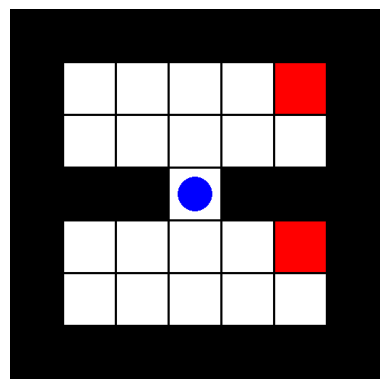

Action: 1, Reward: 0
Observation: [3 3]
Info: {}
Pixels shape: (512, 512, 3)


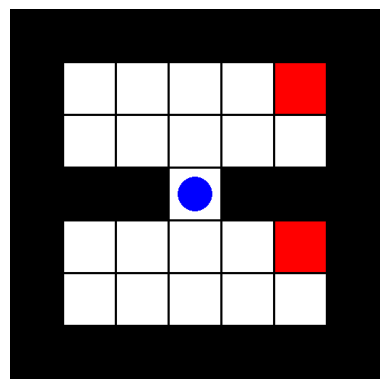

Action: 2, Reward: 0
Observation: [2 3]
Info: {}
Pixels shape: (512, 512, 3)


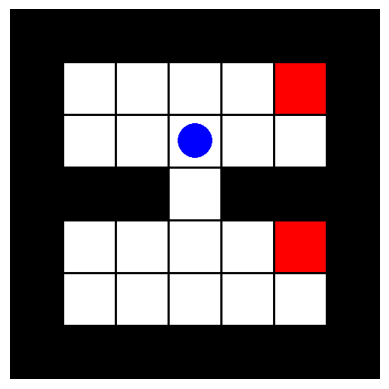

Action: 1, Reward: 0
Observation: [2 4]
Info: {}
Pixels shape: (512, 512, 3)


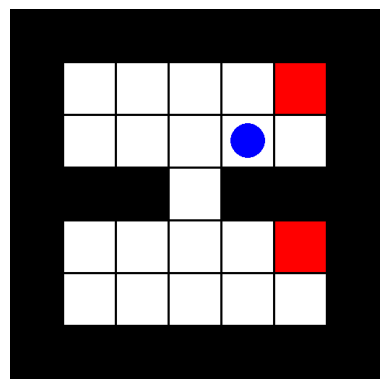

Action: 3, Reward: 0
Observation: [2 3]
Info: {}
Pixels shape: (512, 512, 3)


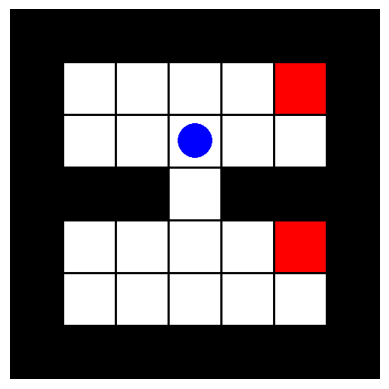

Action: 1, Reward: 0
Observation: [2 4]
Info: {}
Pixels shape: (512, 512, 3)


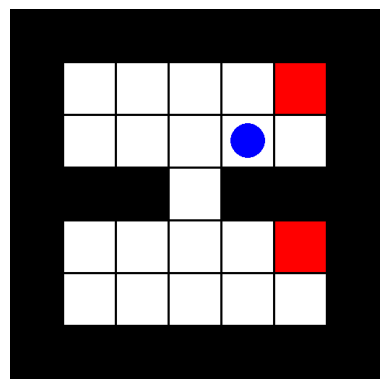

Action: 3, Reward: 0
Observation: [2 3]
Info: {}
Pixels shape: (512, 512, 3)


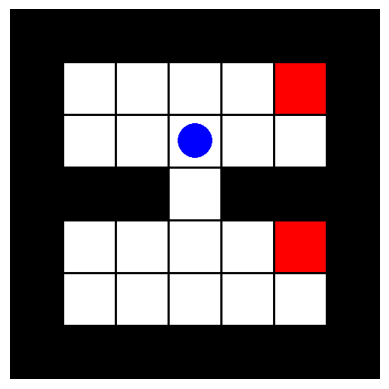

Action: 3, Reward: 0
Observation: [2 2]
Info: {}
Pixels shape: (512, 512, 3)


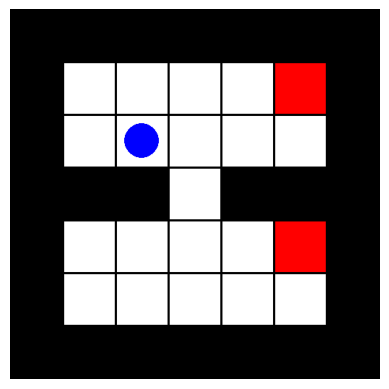

Action: 3, Reward: 0
Observation: [2 1]
Info: {}
Pixels shape: (512, 512, 3)


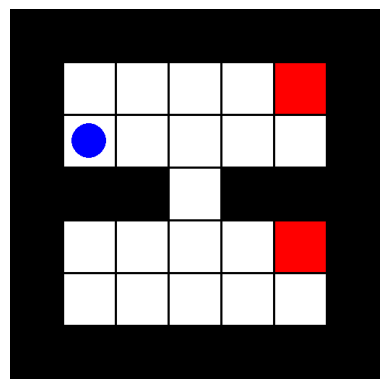

Action: 0, Reward: 0
Observation: [2 1]
Info: {}
Pixels shape: (512, 512, 3)


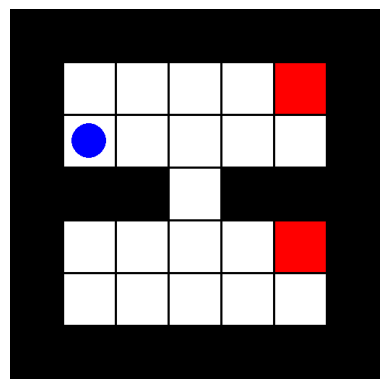

In [128]:
# Check GridWorldEnv
env = gym.make("GridWorldEnv-v0", render_mode="rgb_array", grid_file='custom_envs/grid_envs/grid_world2.txt')

# Reset the environment
observation, info = env.reset(seed=42)
print("Initial Observation:", observation)
print("Initial Info:", info)

# Step through the environment

for _ in range(10):
    # Random action
    action = np.random.randint(env.action_space.n)
    observation, reward, terminated, truncated, info = env.step(action)

    print(f"Action: {action}, Reward: {reward}")
    print(f"Observation: {observation}")
    print(f"Info: {info}")

    # Render the environment
    pixels = env.render()
    print(f"Pixels shape: {pixels.shape}")
    plt.imshow(pixels)
    plt.axis('off')
    plt.show()

    if terminated or truncated:
        observation, info = env.reset()

# Action 0: Down
# Action 1: Right
# Action 2: Up
# Action 3: Left

In [129]:
from torchrl.envs import GymWrapper
import gymnasium as gym

env = gym.make("GridWorldEnv-v0", render_mode = "rgb_array", grid_file='custom_envs/grid_envs/grid_world2.txt')
env = GymWrapper(env, from_pixels=True, pixels_only=False, device="cpu")
print(env.spec.max_episode_steps)

200


In [130]:
data = env.rollout(10)

In [131]:
data

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([10, 4]), device=cpu, dtype=torch.int64, is_shared=False),
        done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([10, 2]), device=cpu, dtype=torch.int32, is_shared=False),
                pixels: Tensor(shape=torch.Size([10, 512, 512, 3]), device=cpu, dtype=torch.uint8, is_shared=False),
                reward: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                terminated: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
            batch_size=torch.Size([10]),
            device=cpu,
      

Agent: tensor([4, 2], dtype=torch.int32)
Done main: tensor([False])
Done info: tensor([False])


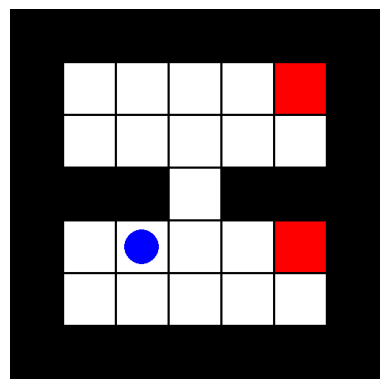

Action: tensor([0, 0, 0, 1])
Agent: tensor([4, 1], dtype=torch.int32)
Done main: tensor([False])
Done info: tensor([False])


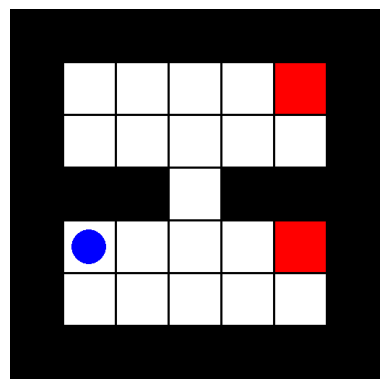

Action: tensor([1, 0, 0, 0])
Agent: tensor([5, 1], dtype=torch.int32)
Done main: tensor([False])
Done info: tensor([False])


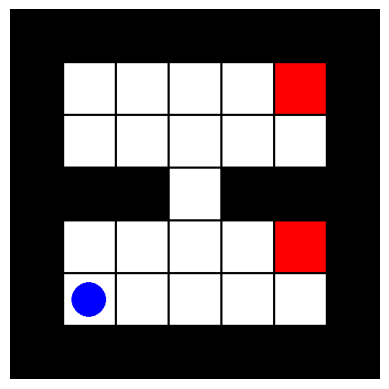

Action: tensor([1, 0, 0, 0])
Agent: tensor([5, 1], dtype=torch.int32)
Done main: tensor([False])
Done info: tensor([False])


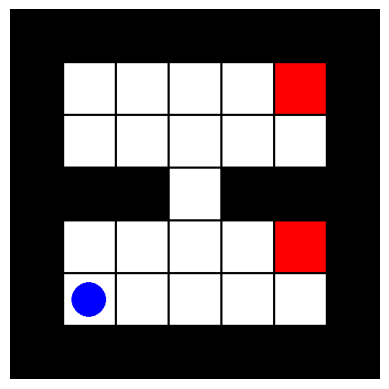

Action: tensor([0, 1, 0, 0])
Agent: tensor([5, 2], dtype=torch.int32)
Done main: tensor([False])
Done info: tensor([False])


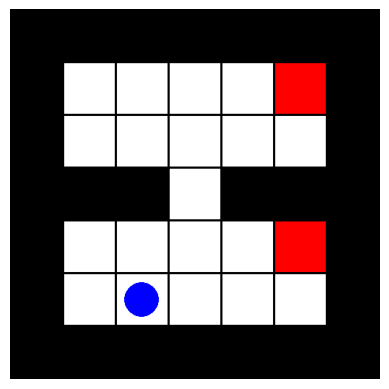

Action: tensor([0, 0, 0, 1])
Agent: tensor([5, 1], dtype=torch.int32)
Done main: tensor([False])
Done info: tensor([False])


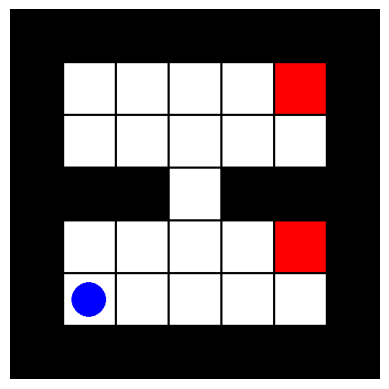

Action: tensor([1, 0, 0, 0])
Agent: tensor([5, 1], dtype=torch.int32)
Done main: tensor([False])
Done info: tensor([False])


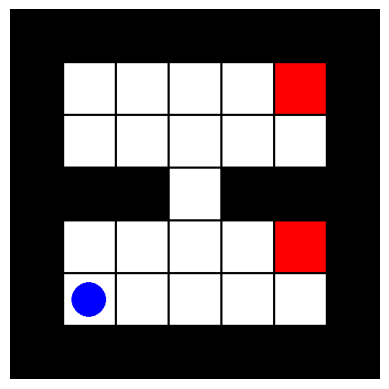

Action: tensor([1, 0, 0, 0])
Agent: tensor([5, 1], dtype=torch.int32)
Done main: tensor([False])
Done info: tensor([False])


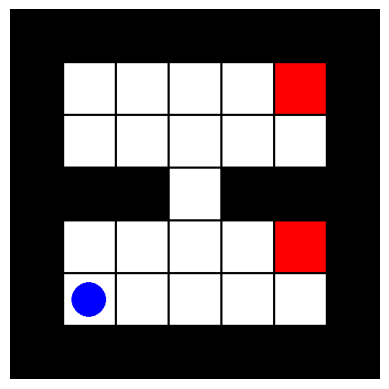

Action: tensor([0, 0, 1, 0])
Agent: tensor([4, 1], dtype=torch.int32)
Done main: tensor([False])
Done info: tensor([False])


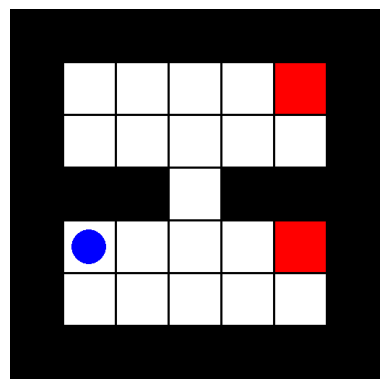

Action: tensor([1, 0, 0, 0])
Agent: tensor([5, 1], dtype=torch.int32)
Done main: tensor([False])
Done info: tensor([False])


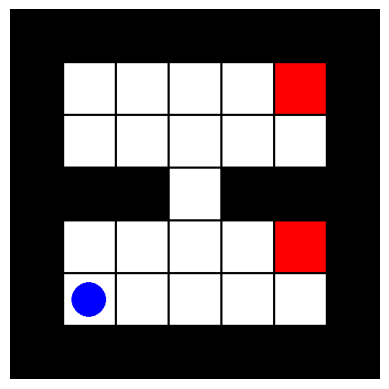

Action: tensor([0, 1, 0, 0])


In [132]:
# Plot the first pixels image
import matplotlib.pyplot as plt

for i in range(10):
    print(f"Agent: {data['observation'][i]}")
    print(f"Done main: {data['done'][i]}")
    print(f"Done info: {data['next', 'done'][i]}")
    plt.imshow(data["pixels"][i])
    plt.axis('off')
    plt.show()
    print(f"Action: {data['action'][i]}")


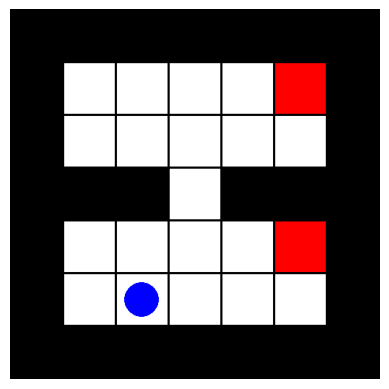

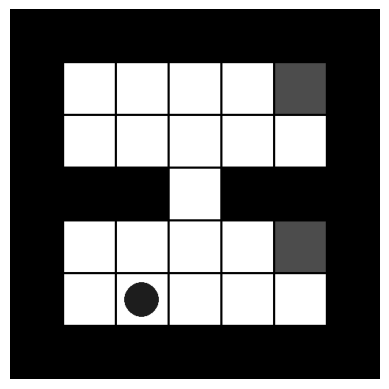

In [133]:
plt.imshow(data['next','pixels'][-1].numpy())
plt.axis('off')
plt.show()

# convert a numpy to a gray scale image
# with PIL
from PIL import Image
import numpy

# Create a numpy array

# Create a numpy array
numpy_array = data['next','pixels'][-1].numpy()

# Create a PIL Image from the numpy array
image = Image.fromarray(numpy_array)

# Convert the PIL image to a gray scale image
gray_image = image.convert('L')

# Display the gray scale image
plt.imshow(gray_image, cmap='gray')
plt.axis('off')
plt.show()


In [23]:
data

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([10, 4]), device=cpu, dtype=torch.int64, is_shared=False),
        agent: Tensor(shape=torch.Size([10, 2]), device=cpu, dtype=torch.int64, is_shared=False),
        done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                agent: Tensor(shape=torch.Size([10, 2]), device=cpu, dtype=torch.int64, is_shared=False),
                done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                pixels: Tensor(shape=torch.Size([10, 512, 512, 3]), device=cpu, dtype=torch.uint8, is_shared=False),
                reward: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                target: Tensor(shape=torch.Size([10, 2]), device=cpu, dtype=torch.int64, is_shared=False),
                terminated: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, 

In [17]:
data["observation"][0]

KeyError: 'key "observation" not found in TensorDict with keys [\'action\', \'agent\', \'done\', \'next\', \'pixels\', \'target\', \'terminated\', \'truncated\']'

In [22]:
import gymnasium
print(gym.__version__)

0.29.1


In [40]:
from torchrl.envs.utils import RandomPolicy
    
policy = RandomPolicy(env.action_spec)

collector = SyncDataCollector(
    create_env_fn=env,
    policy=policy,
    frames_per_batch=4,
    total_frames=16000,
    device="cpu",
    storing_device="cpu",
    max_frames_per_traj=-1,
    init_random_frames=1000,
)

for data in collector:
    print(data)
    break

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([4, 2]), device=cpu, dtype=torch.int64, is_shared=False),
        collector: TensorDict(
            fields={
                traj_ids: Tensor(shape=torch.Size([4]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([4]),
            device=cpu,
            is_shared=False),
        done: Tensor(shape=torch.Size([4, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        episode_reward: Tensor(shape=torch.Size([4, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([4, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                episode_reward: Tensor(shape=torch.Size([4, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                observation: Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                pixels: Tensor(shape=torch.

In [41]:
data

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([4, 2]), device=cpu, dtype=torch.int64, is_shared=False),
        collector: TensorDict(
            fields={
                traj_ids: Tensor(shape=torch.Size([4]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([4]),
            device=cpu,
            is_shared=False),
        done: Tensor(shape=torch.Size([4, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        episode_reward: Tensor(shape=torch.Size([4, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([4, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                episode_reward: Tensor(shape=torch.Size([4, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                observation: Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                pixels: Tensor(shape=torch.

In [42]:
class DQNNetwork(torch.nn.Module):
    """The convolutional network used to compute the agent's Q-values."""
    def __init__(self, 
                 input_shape,
                 num_outputs,
                 num_cells_cnn, 
                 kernel_sizes, 
                 strides, 
                 num_cells_mlp,
                 activation_class,
                 use_batch_norm=False):
        super(DQNNetwork, self).__init__()

        self.activation_class = activation_class()
        self.use_batch_norm = use_batch_norm
      
        # Input shape example: (10, 4, 84, 84)
        _, channels, width, height = input_shape
        self.num_outputs = num_outputs

        # Xavier (Glorot) uniform initialization
        self.initializer = torch.nn.init.xavier_uniform_

        # Convolutional layers
        self.conv_layers = torch.nn.ModuleList()
        self.batch_norm_layers = torch.nn.ModuleList()
        in_channels = channels
        for out_channels, kernel_size, stride in zip(num_cells_cnn, kernel_sizes, strides):
            conv_layer = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)
            self.conv_layers.append(conv_layer)
            if self.use_batch_norm:
                batch_norm_layer = torch.nn.BatchNorm2d(out_channels)
                self.batch_norm_layers.append(batch_norm_layer)
            in_channels = out_channels

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size, stride):
            return (size - kernel_size) // stride  + 1
        
        # Compute the output shape of the conv layers
        width_output = width
        height_output = height
        for kernel_size, stride in zip(kernel_sizes, strides):
            width_output = conv2d_size_out(width_output, kernel_size, stride)
            height_output = conv2d_size_out(height_output, kernel_size, stride)

        cnn_output = width_output * height_output * num_cells_cnn[-1]

        # Fully connected layers
        input_size = cnn_output

        if len(num_cells_mlp) != 0:
            self.fc_layers = torch.nn.ModuleList()
            for units in num_cells_mlp:
                fc_layer = torch.nn.Linear(input_size, units)
                self.fc_layers.append(fc_layer)
                input_size = units
        else:
            self.fc_layers = None
        
        # Final output layer
        self.output_layer = torch.nn.Linear(input_size, self.num_outputs)

        self._initialize_weights()

    def _initialize_weights(self):
        for layer in self.conv_layers:
            self.initializer(layer.weight)
            if layer.bias is not None:
                torch.nn.init.zeros_(layer.bias)
        if self.fc_layers is not None:
            for layer in self.fc_layers:
                self.initializer(layer.weight)
                if layer.bias is not None:
                    torch.nn.init.zeros_(layer.bias)
        self.initializer(self.output_layer.weight)
        if self.output_layer.bias is not None:
            torch.nn.init.zeros_(self.output_layer.bias)

    def forward(self, x):
        # x = x.float() / 255.0 # Already normalized by VecNorm
        for i, conv_layer in enumerate(self.conv_layers):
            x = conv_layer(x)
            if self.use_batch_norm:
                x = self.batch_norm_layers[i](x)
            x = self.activation_class(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor

        if self.fc_layers is not None:
            for fc_layer in self.fc_layers:
                x = self.activation_class(fc_layer(x))
        q_values = self.output_layer(x)
        return q_values

In [91]:
class MICODQNNetwork(torch.nn.Module):
    """The convolutional network used to compute the agent's Q-values."""
    def __init__(self, 
                 input_shape,
                 num_outputs,
                 num_cells_cnn, 
                 kernel_sizes, 
                 strides, 
                 num_cells_mlp,
                 activation_class,
                 use_batch_norm=False):
        super(MICODQNNetwork, self).__init__()

        self.activation_class = activation_class()
        self.use_batch_norm = use_batch_norm
      
        # Input shape example: (4, 84, 84)
        channels, width, height = input_shape
        self.num_outputs = num_outputs

        # Xavier (Glorot) uniform initialization
        self.initializer = torch.nn.init.xavier_uniform_

        # Convolutional layers
        self.conv_layers = torch.nn.ModuleList()
        self.batch_norm_layers = torch.nn.ModuleList()
        in_channels = channels
        for out_channels, kernel_size, stride in zip(num_cells_cnn, kernel_sizes, strides):
            conv_layer = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)
            self.conv_layers.append(conv_layer)
            if self.use_batch_norm:
                batch_norm_layer = torch.nn.BatchNorm2d(out_channels)
                self.batch_norm_layers.append(batch_norm_layer)
            in_channels = out_channels

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size, stride):
            return (size - kernel_size) // stride  + 1
        
        # Compute the output shape of the conv layers
        width_output = width
        height_output = height
        for kernel_size, stride in zip(kernel_sizes, strides):
            width_output = conv2d_size_out(width_output, kernel_size, stride)
            height_output = conv2d_size_out(height_output, kernel_size, stride)

        cnn_output = width_output * height_output * num_cells_cnn[-1]

        # Fully connected layers
        input_size = cnn_output

        if len(num_cells_mlp) != 0:
            self.fc_layers = torch.nn.ModuleList()
            for units in num_cells_mlp:
                fc_layer = torch.nn.Linear(input_size, units)
                self.fc_layers.append(fc_layer)
                input_size = units
        else:
            self.fc_layers = None
        
        # Final output layer
        self.output_layer = torch.nn.Linear(input_size, self.num_outputs)

        self._initialize_weights()

    def _initialize_weights(self):
        for layer in self.conv_layers:
            self.initializer(layer.weight)
            if layer.bias is not None:
                torch.nn.init.zeros_(layer.bias)
        if self.fc_layers is not None:
            for layer in self.fc_layers:
                self.initializer(layer.weight)
                if layer.bias is not None:
                    torch.nn.init.zeros_(layer.bias)
        self.initializer(self.output_layer.weight)
        if self.output_layer.bias is not None:
            torch.nn.init.zeros_(self.output_layer.bias)

    def forward(self, input):

        x = input
        for i, conv_layer in enumerate(self.conv_layers):
            x = conv_layer(x)

            # NOTE: The collector uses a tensor for checking something
            # but this tensor is not in batch format, so we need to
            # check if the tensor is in batch format to apply batch norm
            if self.use_batch_norm and len(input.shape) == 4:
                x = self.batch_norm_layers[i](x)
            x = self.activation_class(x)

        if len(input.shape) == 4:
            x = x.view(x.size(0), -1)  # Flatten the tensor
        else:
            x = x.view(-1)
        
        representation = x

        if self.fc_layers is not None:
            for fc_layer in self.fc_layers:
                x = self.activation_class(fc_layer(x))
        q_values = self.output_layer(x)
        return q_values, representation


In [92]:
# Check the network with a random input
tensor = torch.rand(10, 4, 84, 84)
num_actions = 2
num_cells_cnn = [32, 64, 64]
kernel_sizes = [8, 4, 3]
strides = [4, 2, 1]
num_cells_mlp = [512]
activation_class = torch.nn.ReLU

network = MICODQNNetwork(
    input_shape=tensor.shape[-3:],
    num_outputs=num_actions,
    num_cells_cnn=num_cells_cnn,
    kernel_sizes=kernel_sizes,
    strides=strides,
    num_cells_mlp=num_cells_mlp,
    activation_class=activation_class,
    use_batch_norm=True
)
q_values, representation = network(tensor)

In [93]:
network

MICODQNNetwork(
  (activation_class): ReLU()
  (conv_layers): ModuleList(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  )
  (batch_norm_layers): ModuleList(
    (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1-2): 2 x BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=3136, out_features=512, bias=True)
  )
  (output_layer): Linear(in_features=512, out_features=2, bias=True)
)

In [94]:
def make_dqn_modules(proof_environment, policy_cfg):

    # Define input shape
    input_shape = proof_environment.observation_spec["pixels"].shape
    env_specs = proof_environment.specs

    # NOTE: I think I can change the next two lines by
    # num_outputs = proof_environment.action_spec.shape[-1]
    # action_spec = proof_environment.action_spec.space
    num_outputs = env_specs["input_spec", "full_action_spec", "action"].space.n
    action_spec = env_specs["input_spec", "full_action_spec", "action"]

    # Define Q-Value Module and Representations (for MICO)

    activation_class = torch.nn.ReLU

    module = MICODQNNetwork(
        input_shape=input_shape,
        num_outputs=num_outputs,
        num_cells_cnn=policy_cfg.cnn_net.num_cells,
        kernel_sizes=policy_cfg.cnn_net.kernel_sizes,
        strides=policy_cfg.cnn_net.strides,
        num_cells_mlp=policy_cfg.mlp_net.num_cells,
        activation_class=activation_class,
        use_batch_norm=policy_cfg.use_batch_norm
    )

    module = TensorDictModule(module,
            in_keys=["pixels"], 
            out_keys=["action_value", "representation"])

    # NOTE: Do I need CompositeSpec here?
    # I think I only need proof_environment.action_spec
    qvalue_module = QValueActor(
        module=module,
        spec=CompositeSpec(action=action_spec),
        in_keys=["pixels"],
    )

    return qvalue_module

In [95]:
# Load dqn_mico_er/config_cartpole.yaml
import yaml
from omegaconf import OmegaConf

with open("dqn_pixels/config_cartpole.yaml") as f:
    cfg = OmegaConf.create(yaml.safe_load(f))

cfg

{'device': None, 'exp_name': 'DQN_pixels', 'env': {'env_name': 'CartPole-v1', 'seed': 118398}, 'collector': {'total_frames': 5000016, 'frames_per_batch': 16, 'eps_start': 1.0, 'eps_end': 0.05, 'annealing_frames': 200000, 'init_random_frames': 50000, 'frame_skip': 2}, 'policy': {'type': 'CNN_MLP', 'cnn_net': {'num_cells': [32, 64, 64], 'kernel_sizes': [8, 4, 3], 'strides': [4, 2, 1]}, 'mlp_net': {'num_cells': [512]}, 'activation': 'ReLU', 'use_batch_norm': False}, 'buffer': {'buffer_size': 50000, 'batch_size': 128, 'scratch_dir': None, 'prioritized_replay': False, 'alpha': 0.7, 'beta': 0.4}, 'logger': {'backend': 'wandb', 'project_name': 'dqn_pixels_cartpole', 'group_name': None, 'test_interval': 50000, 'num_test_episodes': 3, 'video': False}, 'optim': {'lr': 0.001, 'max_grad_norm': 10}, 'loss': {'gamma': 0.99, 'hard_update_freq': 50, 'num_updates': 1}}

In [96]:
from torchrl.envs.utils import RandomPolicy
from tensordict.nn import TensorDictModule, TensorDictSequential

module = make_dqn_modules(env, cfg.policy)

greedy_module = EGreedyModule(
    annealing_num_steps=1000,
    eps_init=0.9,
    eps_end=0.1,
    spec=module.spec,
)
model_explore = TensorDictSequential(
    module,
    greedy_module,
)

collector = SyncDataCollector(
    create_env_fn=env,
    policy=model_explore,
    frames_per_batch=4,
    total_frames=16000,
    device="cpu",
    storing_device="cpu",
    max_frames_per_traj=-1,
)

for data in collector:
    print(data)
    break

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([4, 2]), device=cpu, dtype=torch.int64, is_shared=False),
        action_value: Tensor(shape=torch.Size([4, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        chosen_action_value: Tensor(shape=torch.Size([4, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        collector: TensorDict(
            fields={
                traj_ids: Tensor(shape=torch.Size([4]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([4]),
            device=cpu,
            is_shared=False),
        done: Tensor(shape=torch.Size([4, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        episode_reward: Tensor(shape=torch.Size([4, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([4, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                episode_reward: Tensor(shape=torch.Si

In [97]:
data

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([4, 2]), device=cpu, dtype=torch.int64, is_shared=False),
        action_value: Tensor(shape=torch.Size([4, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        chosen_action_value: Tensor(shape=torch.Size([4, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        collector: TensorDict(
            fields={
                traj_ids: Tensor(shape=torch.Size([4]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([4]),
            device=cpu,
            is_shared=False),
        done: Tensor(shape=torch.Size([4, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        episode_reward: Tensor(shape=torch.Size([4, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([4, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                episode_reward: Tensor(shape=torch.Si

In [105]:
data['next','done']

tensor([[False],
        [False],
        [ True],
        [False]])

In [110]:
data['next','pixels'][2]


tensor([[[1.1921e-05, 1.1921e-05, 1.1921e-05,  ..., 1.1921e-05,
          1.1921e-05, 1.1921e-05],
         [5.9605e-06, 1.1921e-05, 1.1921e-05,  ..., 1.1921e-05,
          1.7881e-05, 1.1921e-05],
         [1.7881e-05, 1.7881e-05, 1.7881e-05,  ..., 1.7881e-05,
          1.1921e-05, 1.7881e-05],
         ...,
         [5.9605e-06, 1.1921e-05, 1.1921e-05,  ..., 1.1921e-05,
          1.1921e-05, 1.1921e-05],
         [5.9605e-06, 1.1921e-05, 1.1921e-05,  ..., 1.1921e-05,
          1.1921e-05, 1.1921e-05],
         [1.1921e-05, 1.1921e-05, 1.1921e-05,  ..., 1.1921e-05,
          1.7881e-05, 1.1921e-05]],

        [[1.1921e-05, 1.1921e-05, 1.1921e-05,  ..., 1.1921e-05,
          1.1921e-05, 1.1921e-05],
         [5.9605e-06, 1.1921e-05, 1.1921e-05,  ..., 1.1921e-05,
          1.7881e-05, 1.1921e-05],
         [1.7881e-05, 1.7881e-05, 1.7881e-05,  ..., 1.7881e-05,
          1.1921e-05, 1.7881e-05],
         ...,
         [5.9605e-06, 1.1921e-05, 1.1921e-05,  ..., 1.1921e-05,
          1.192

In [108]:
data['next','pixels'][2]


tensor([[[1.1921e-05, 1.1921e-05, 1.1921e-05,  ..., 1.1921e-05,
          1.1921e-05, 1.1921e-05],
         [5.9605e-06, 1.1921e-05, 1.1921e-05,  ..., 1.1921e-05,
          1.7881e-05, 1.1921e-05],
         [1.7881e-05, 1.7881e-05, 1.7881e-05,  ..., 1.7881e-05,
          1.1921e-05, 1.7881e-05],
         ...,
         [5.9605e-06, 1.1921e-05, 1.1921e-05,  ..., 1.1921e-05,
          1.1921e-05, 1.1921e-05],
         [5.9605e-06, 1.1921e-05, 1.1921e-05,  ..., 1.1921e-05,
          1.1921e-05, 1.1921e-05],
         [1.1921e-05, 1.1921e-05, 1.1921e-05,  ..., 1.1921e-05,
          1.7881e-05, 1.1921e-05]],

        [[1.1921e-05, 1.1921e-05, 1.1921e-05,  ..., 1.1921e-05,
          1.1921e-05, 1.1921e-05],
         [5.9605e-06, 1.1921e-05, 1.1921e-05,  ..., 1.1921e-05,
          1.7881e-05, 1.1921e-05],
         [1.7881e-05, 1.7881e-05, 1.7881e-05,  ..., 1.7881e-05,
          1.1921e-05, 1.7881e-05],
         ...,
         [5.9605e-06, 1.1921e-05, 1.1921e-05,  ..., 1.1921e-05,
          1.192

In [103]:
data['representation']

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0704, 0.0711, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0824, 0.0610, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0814, 0.0059, 0.0000],
        [0.0000, 0.0000, 0.0010,  ..., 0.0142, 0.0028, 0.0000]])

In [ ]:
q_values.shape, representation.shape

(torch.Size([10, 2]), torch.Size([10, 3136]))

In [ ]:
# Check the network with a random input
tensor = torch.rand(10, 4, 84, 84)
num_actions = 2
num_cells_cnn = [64, 64, 32]
kernel_sizes = [5, 5, 5]
strides = [2, 2, 2]
num_cells_mlp = []
activation_class = torch.nn.ReLU

network = DQNNetwork(
    input_shape=tensor.shape,
    num_outputs=num_actions,
    num_cells_cnn=num_cells_cnn,
    kernel_sizes=kernel_sizes,
    strides=strides,
    num_cells_mlp=num_cells_mlp,
    activation_class=activation_class,
    use_batch_norm=True
)
q_values = network(tensor)

In [ ]:
network

DQNNetwork(
  (activation_class): ReLU()
  (conv_layers): ModuleList(
    (0): Conv2d(4, 64, kernel_size=(5, 5), stride=(2, 2))
    (1): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2))
    (2): Conv2d(64, 32, kernel_size=(5, 5), stride=(2, 2))
  )
  (batch_norm_layers): ModuleList(
    (0-1): 2 x BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output_layer): Linear(in_features=1568, out_features=2, bias=True)
)

In [ ]:
q_values.shape, representation.shape

(torch.Size([10, 2]), torch.Size([10, 3136]))

In [ ]:
from torchrl.modules import ConvNet

cnn = ConvNet(
    activation_class=torch.nn.ReLU,
    num_cells=[32, 64, 64],
    kernel_sizes=[8, 4, 3],
    strides=[4, 2, 1])
cnn

/home/zosov/anaconda3/envs/final-project/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


ConvNet(
  (0): LazyConv2d(0, 32, kernel_size=(8, 8), stride=(4, 4))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (3): ReLU()
  (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
  (6): SquashDims()
)

In [ ]:
# check the network with a toy input
x = torch.randn(1, 4, 84, 84)
y = cnn(x)
y.shape


torch.Size([1, 3136])

In [ ]:
84 * 84 * 4


28224

In [ ]:
# 1 2 3 4 5 6 7 8 9 10

In [ ]:
# NOTE: a rollout will be take a trajectory of frame of 10 steps and will concat them by N = 4
# so the output will be 7x4x84x84
env.rollout(max_steps=10)

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([3, 2]), device=cpu, dtype=torch.int64, is_shared=False),
        done: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        episode_reward: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                episode_reward: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                observation: Tensor(shape=torch.Size([3, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                pixels: Tensor(shape=torch.Size([3, 4, 84, 84]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                step_count: Tensor(shape=torch.Size([3, 1]), device=cpu

In [ ]:
env = TransformedEnv(GymEnv("CartPole-v1"), StepCounter())
env

/home/zosov/anaconda3/envs/final-project/lib/python3.11/site-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 it will default to `None`. With a device of None, no device casting is performed and the resulting tensordicts are deviceless. Please set your device accordingly.
  warnings.warn(


TransformedEnv(
    env=GymEnv(env=CartPole-v1, batch_size=torch.Size([]), device=cpu),
    transform=StepCounter(keys=[]))

In [ ]:
rollout = env.rollout(max_steps=10)

In [ ]:
# # considering rollout['pixels'].shape equal torch.Size([10, 400, 600, 3]), plot the 10 images
# import matplotlib.pyplot as plt

# fig, axs = plt.subplots(1, 10, figsize=(20, 2))
# for i, ax in enumerate(axs):
#     ax.imshow(rollout['pixels'][i])
#     ax.axis('off')
# plt.show()

In [111]:
class MICOMLPNetwork(torch.nn.Module):
    def __init__(self,
                 in_features,
                 activation_class, 
                 encoder_out_features,
                 mlp_out_features,
                 encoder_num_cells = None,
                 mlp_num_cells = None):
        super(MICOMLPNetwork, self).__init__()

        self.activation = activation_class()

        if encoder_num_cells is None:
            encoder_num_cells = []
        layers_sizes = [in_features] + encoder_num_cells + [encoder_out_features]

        self.encoder = torch.nn.ModuleList()
        for i in range(len(layers_sizes) - 1):
            self.encoder.append(torch.nn.Linear(layers_sizes[i], layers_sizes[i+1]))

        if mlp_num_cells is None:
            mlp_num_cells = []

        layers_sizes = [encoder_out_features] + mlp_num_cells + [mlp_out_features.item()]

        self.q_net = torch.nn.ModuleList()
        for i in range(len(layers_sizes) - 1):
            self.q_net.append(torch.nn.Linear(layers_sizes[i], layers_sizes[i+1]))
        
    
    def forward(self, x):
        for i in range(len(self.encoder)):
            x = self.activation(self.encoder[i](x))

        representation = x

        for i in range(len(self.q_net)-1):
            x = self.activation(self.q_net[i](x))

        return self.q_net[-1](x), representation

In [112]:
value_mlp = MICOMLPNetwork(
    in_features=4,
    activation_class=torch.nn.ReLU,
    encoder_out_features=3,
    mlp_out_features=env.action_spec.shape[-1],
    encoder_num_cells=[64],
    mlp_num_cells=[64]
)

value_mlp

MICOMLPNetwork(
  (activation): ReLU()
  (encoder): ModuleList(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=3, bias=True)
  )
  (q_net): ModuleList(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [113]:
import numpy as np

# Specifications
num_observations = 4
cart_position_min = -4.8
cart_position_max = 4.8
cart_velocity_min = -np.inf
cart_velocity_max = np.inf
pole_angle_min = -0.418
pole_angle_max = 0.418
pole_angular_velocity_min = -np.inf
pole_angular_velocity_max = np.inf

def create_batched_random_tensor(n):
    # Creating the batched random tensor
    cart_position = np.random.uniform(cart_position_min, cart_position_max, size=n)
    cart_velocity = np.random.normal(loc=0.0, scale=10.0, size=n)  # Assuming normal distribution with large std deviation
    pole_angle = np.random.uniform(pole_angle_min, pole_angle_max, size=n)
    pole_angular_velocity = np.random.normal(loc=0.0, scale=10.0, size=n)  # Assuming normal distribution with large std deviation

    # Combining into a single tensor of shape (n, 4)
    batched_tensor = np.stack((cart_position, cart_velocity, pole_angle, pole_angular_velocity), axis=-1)
    
    return batched_tensor

# Example usage with batch size n = 5
n = 100
batched_tensor = torch.tensor(create_batched_random_tensor(n), dtype=torch.float32)
print(batched_tensor)

tensor([[-2.4385e-01,  1.6361e+01,  1.6819e-01,  1.6592e+01],
        [-2.4529e+00,  6.2587e+00,  2.1316e-01, -1.7105e+01],
        [ 1.0673e+00,  6.0321e-01,  4.1905e-02, -6.5497e+00],
        [-2.2201e+00, -5.3833e+00, -5.6525e-02, -2.0494e+01],
        [ 2.4468e+00,  1.3530e-01,  8.5826e-02, -7.4412e+00],
        [-1.0956e+00, -1.7736e+01, -2.9005e-01,  5.1246e+00],
        [-8.3562e-02,  5.9217e+00, -3.8831e-01, -1.0923e+01],
        [-9.6649e-02, -1.7004e+01,  1.8255e-01,  5.0339e+00],
        [-1.9215e+00, -6.0012e+00, -3.3985e-01, -1.9400e+00],
        [-7.9192e-01, -8.4512e+00, -1.1339e-01, -2.4514e+00],
        [-3.8455e+00, -4.1582e+00, -6.5327e-02, -6.5401e+00],
        [ 2.5188e+00, -2.6075e-01, -4.0146e-01, -4.9766e+00],
        [ 3.4100e+00, -5.7687e+00, -1.3475e-01, -4.9081e+00],
        [-3.0499e+00,  1.7682e+01,  2.6956e-01,  6.2869e+00],
        [ 3.5047e+00, -1.3430e+01,  3.0075e-01, -9.5426e+00],
        [ 3.7697e+00,  1.1834e+01,  1.7286e-01,  1.1398e+01],
        

In [114]:
import torch.nn as nn
import torch.optim as optim

# Initialize the network
# network = MICOMLPNetwork(in_features=4,
#                          activation_class=torch.nn.ReLU, 
#                          encoder_out_features=8,
#                          mlp_out_features=1,
#                          encoder_num_cells=[16],
#                          mlp_num_cells=[8])

network = MICOMLPNetwork(
    in_features=4,
    activation_class=torch.nn.ReLU,
    encoder_out_features=3,
    mlp_out_features=env.action_spec.shape[-1],
    encoder_num_cells=[128],
    mlp_num_cells=[64]
)

# Define dummy target tensors for losses
target_representation = torch.randn(100, 2)  # Assuming the representation has 8 features
target_q_values = torch.randn(100, 2)  # Assuming the Q-values have 1 feature

# Define loss functions
criterion_representation = nn.MSELoss()
criterion_q_values = nn.MSELoss()

# Define an optimizer
optimizer = optim.Adam(network.parameters(), lr=0.001)

# Forward pass
q_values, representation = network(batched_tensor)

# Compute the losses
# loss_representation = criterion_representation(representation, target_representation)
# loss_q_values = criterion_q_values(q_values, target_q_values)

# # Sum the losses
# total_loss = loss_representation + loss_q_values

# # Backward pass and optimization
# optimizer.zero_grad()
# total_loss.backward()
# optimizer.step()

# # Print losses
# print(f"Total Loss: {total_loss.item()}, Loss Representation: {loss_representation.item()}, Loss Q-Values: {loss_q_values.item()}")

In [115]:
# # Print the gradients of the total_loss
# for name, param in network.named_parameters():
#     print(name, param.grad)

In [116]:
# toy_example = torch.tensor(batched_tensor, dtype=torch.float32)
# q_values, representation = value_mlp(toy_example)
# print(q_values)
# print(representation)

In [117]:
value_net = Mod(network, 
                in_keys=["observation"], 
                out_keys=["action_value", "representation"])
value_net

TensorDictModule(
    module=MICOMLPNetwork(
      (activation): ReLU()
      (encoder): ModuleList(
        (0): Linear(in_features=4, out_features=128, bias=True)
        (1): Linear(in_features=128, out_features=3, bias=True)
      )
      (q_net): ModuleList(
        (0): Linear(in_features=3, out_features=64, bias=True)
        (1): Linear(in_features=64, out_features=2, bias=True)
      )
    ),
    device=cpu,
    in_keys=['observation'],
    out_keys=['action_value', 'representation'])

In [118]:
# policy = Seq(value_net, 
#              QValueModule(spec=env.action_spec))
# policy

policy = QValueActor(
    module=value_net,
    spec=CompositeSpec(action= env.specs["input_spec", "full_action_spec", "action"]),
    in_keys=["observation"],
)
policy

QValueActor(
    module=ModuleList(
      (0): TensorDictModule(
          module=MICOMLPNetwork(
            (activation): ReLU()
            (encoder): ModuleList(
              (0): Linear(in_features=4, out_features=128, bias=True)
              (1): Linear(in_features=128, out_features=3, bias=True)
            )
            (q_net): ModuleList(
              (0): Linear(in_features=3, out_features=64, bias=True)
              (1): Linear(in_features=64, out_features=2, bias=True)
            )
          ),
          device=cpu,
          in_keys=['observation'],
          out_keys=['action_value', 'representation'])
      (1): QValueModule()
    ),
    device=cpu,
    in_keys=['observation'],
    out_keys=['representation', 'action', 'action_value', 'chosen_action_value'])

In [119]:
# Define the exploration step (e-greedy policy)
exploration_module = EGreedyModule(
    env.action_spec, 
    annealing_num_steps=100_000, 
    eps_init=0.1,
)
policy_explore = Seq(policy, 
                     exploration_module)
policy_explore

TensorDictSequential(
    module=ModuleList(
      (0): QValueActor(
          module=ModuleList(
            (0): TensorDictModule(
                module=MICOMLPNetwork(
                  (activation): ReLU()
                  (encoder): ModuleList(
                    (0): Linear(in_features=4, out_features=128, bias=True)
                    (1): Linear(in_features=128, out_features=3, bias=True)
                  )
                  (q_net): ModuleList(
                    (0): Linear(in_features=3, out_features=64, bias=True)
                    (1): Linear(in_features=64, out_features=2, bias=True)
                  )
                ),
                device=cpu,
                in_keys=['observation'],
                out_keys=['action_value', 'representation'])
            (1): QValueModule()
          ),
          device=cpu,
          in_keys=['observation'],
          out_keys=['representation', 'action', 'action_value', 'chosen_action_value'])
      (1): EGreedyModule()
 

In [120]:
# Define how to collect the data (experiences)
init_rand_steps = 5000 # warm-up steps
frames_per_batch = 100
optim_steps = 10
replay_capacity = 100_000

# NOTE: collector will gather rollouts continously
# If the current trajectory ends, it will start a new one
# NOTE: the rollout gotten from the collector is a dictionary
# that defines the sate and next state as a tensor with a batch dimension in the begining
# for example a rollout of 10 steps will have a tensor of observation of 10 in the batch dimension
# and the next will also have 10 which are all the tensors of the next state
# Practically, next is as you will shift the tensor of observation by one step
# collector = SyncDataCollector(
#     env,
#     policy_explore,
#     frames_per_batch=frames_per_batch,
#     total_frames=500_100,
#     init_random_frames=init_rand_steps,
# )
# rb = ReplayBuffer(storage=LazyTensorStorage(replay_capacity))

In [121]:
# Define the recording and logging
path = "./training_loop"
logger = CSVLogger(exp_name="dqn", log_dir=path, video_format="mp4")
video_recorder = VideoRecorder(logger, tag="video")
record_env = TransformedEnv(
    GymEnv("CartPole-v1", from_pixels=True, pixels_only=False), video_recorder
)

/home/zosov/anaconda3/envs/final-project/lib/python3.11/site-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 it will default to `None`. With a device of None, no device casting is performed and the resulting tensordicts are deviceless. Please set your device accordingly.
  warnings.warn(


In [210]:
# collector = SyncDataCollector(
#     env,
#     policy_explore,
#     frames_per_batch=10,
#     total_frames=500_100,
#     init_random_frames=10000,
# )

collector = SyncDataCollector(
    create_env_fn=env,
    policy=policy_explore,
    frames_per_batch=10,
    total_frames=100,
    device="cpu",
    storing_device="cpu",
    max_frames_per_traj=-1
)
# NOTE: IMPORTANTISIMO en las primeras iteraciones no se usa la policy, entonces representation se configura
# a zero, por lo que el primer batch de datos no tiene representation
# Tengo que hacer el warm-up de otra manera (ojo con esto)

for data in collector:
    print(data['representation'])
    break

tensor([[0.0000, 0.0873, 0.2517],
        [0.0000, 0.0238, 0.1848],
        [0.0000, 0.0000, 0.3682],
        [0.0000, 0.0874, 0.2489],
        [0.0000, 0.0206, 0.1842],
        [0.0000, 0.0000, 0.3667],
        [0.0000, 0.0905, 0.2513],
        [0.0000, 0.0148, 0.1964],
        [0.0000, 0.0970, 0.2523],
        [0.0000, 0.0000, 0.2323]])


In [202]:
data

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([10, 2]), device=cpu, dtype=torch.int64, is_shared=False),
        action_value: Tensor(shape=torch.Size([10, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        chosen_action_value: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        collector: TensorDict(
            fields={
                traj_ids: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([10]),
            device=cpu,
            is_shared=False),
        done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        episode_reward: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                episode_reward: Tensor(shape=

In [203]:
data['next','done']

tensor([[False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [ True]])

In [204]:
data['next','reward']

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [194]:
def get_next_next_rewards(rewards, dones):
    next_next_rewards = rewards.clone().roll(-1, dims=0)
    next_next_rewards[dones] = 0
    return next_next_rewards

In [205]:
next_next_rewards = get_next_next_rewards(data['next','reward'], data['next','done'])

next_next_rewards

tensor([[1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.]])

In [206]:
if data.device is not None:
    next_next_rewards = next_next_rewards.to(data.device)

data.set(
    ("next", "next_reward"),
    next_next_rewards,
    inplace=True,
)
data

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([10, 2]), device=cpu, dtype=torch.int64, is_shared=False),
        action_value: Tensor(shape=torch.Size([10, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        chosen_action_value: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        collector: TensorDict(
            fields={
                traj_ids: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([10]),
            device=cpu,
            is_shared=False),
        done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        episode_reward: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                episode_reward: Tensor(shape=

In [197]:
arr = torch.tensor([1, 2, 3, 4, 5])
arr[:-1]

tensor([1, 2, 3, 4])

In [207]:
if not data['next','done'][-1]:
    # next_next_rewards[-1] = 0 # Set according the reward of the env 
                              # in cartpole will be one so I don't need to do anything
    # NOTE: Better remove that last step to avoid problems
    data = data[:-1]

In [214]:
def update_tensor_dict_next_next_reward(tensordict):

    def get_next_next_rewards(rewards, dones):
        next_next_rewards = rewards.clone().roll(-1, dims=0)
        next_next_rewards[dones] = 0
        return next_next_rewards

    next_next_rewards = get_next_next_rewards(tensordict['next','reward'], tensordict['next','done'])

    if tensordict.device is not None:
        next_next_rewards = next_next_rewards.to(tensordict.device)

    tensordict.set(
        ("next", "next_reward"),
        next_next_rewards,
        inplace=True,
    )

    # Side effect of the last step. As we cannot get the next_next_reward of the last step
    # we need to remove it or assign it to a value that we know for sure like in cartpole
    # will be always be one, and zero if it is done True.

    # NOTE: We comment this part, because we are using the cartpole environment, but 
    # uncomment and update properly depending the case
    # if not tensordict['next','done'][-1]:
    #     # Two options
    #     # 1. Assign a value
    #     # next_next_rewards[-1] = 1 # Set according the reward of the env 
    #                                # in cartpole will be one so I don't need to do anything
    #                                # in cartpole I don't need even to assign because all are 1
    #     # 2. Remove that last step to avoid problems
    #     data = data[:-1] 

    return tensordict

In [215]:
data

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([10, 2]), device=cpu, dtype=torch.int64, is_shared=False),
        action_value: Tensor(shape=torch.Size([10, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        chosen_action_value: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        collector: TensorDict(
            fields={
                traj_ids: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([10]),
            device=cpu,
            is_shared=False),
        done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        episode_reward: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                episode_reward: Tensor(shape=

In [216]:
data = update_tensor_dict_next_next_reward(data)
data

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([10, 2]), device=cpu, dtype=torch.int64, is_shared=False),
        action_value: Tensor(shape=torch.Size([10, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        chosen_action_value: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        collector: TensorDict(
            fields={
                traj_ids: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([10]),
            device=cpu,
            is_shared=False),
        done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        episode_reward: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                episode_reward: Tensor(shape=

In [157]:
tmp_next_next_reward = data['next','reward'].clone()
tmp_next_next_reward

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [164]:
data['next','done']

tensor([[False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [ True],
        [False]])

In [166]:
next_next_mask = data['next','done'].clone().roll(1, dims=0)
next_next_mask[0] = True

In [169]:
reward_temp = torch.tensor([1, 2, 3, 10, 20, 100, 200])
reward_temp

tensor([  1,   2,   3,  10,  20, 100, 200])

In [172]:
mask = torch.tensor([False, False, True, False, True, False, True])
mask

tensor([False, False,  True, False,  True, False,  True])

In [171]:
reward_temp.roll(-1, dims=0)

tensor([  2,   3,  10,  20, 100, 200,   1])

In [173]:
reward_temp.roll(-1, dims=0)[mask]

tensor([ 10, 100,   1])

In [185]:
reward_temp = torch.tensor([1, 2, 3, 10, 20, 100, 200, 1000])
reward_temp

tensor([   1,    2,    3,   10,   20,  100,  200, 1000])

In [186]:
mask = torch.tensor([False, False, True, False, True, False, True, False])
mask

tensor([False, False,  True, False,  True, False,  True, False])

In [187]:
get_next_next_rewards(reward_temp, mask)

tensor([  2,   3,   0,  20,   0, 200,   0,   1])

In [188]:
reward_temp = torch.tensor([3, 10, 20, 100, 200, 1000])
reward_temp

tensor([   3,   10,   20,  100,  200, 1000])

In [189]:
mask = torch.tensor([ True, False, True, False, True, False])
mask

tensor([ True, False,  True, False,  True, False])

In [190]:
get_next_next_rewards(reward_temp, mask)

tensor([  0,  20,   0, 200,   0,   3])

In [126]:
data['next','observation'][2]

tensor([-0.1196, -1.7470,  0.2361,  2.8161])

In [145]:
data['next','observation']

tensor([[-0.0037, -0.7668,  0.0538,  1.1900],
        [-0.0885, -1.5509,  0.1867,  2.4725],
        [-0.1196, -1.7470,  0.2361,  2.8161],
        [-0.0581, -0.7588,  0.0363,  1.1615],
        [-0.0955,  0.0178,  0.0960,  0.0764],
        [-0.1176, -0.7678,  0.1408,  1.3712],
        [-0.1755, -1.3575,  0.2432,  2.3923],
        [-0.0218, -0.7441,  0.0790,  1.2167],
        [-0.1049, -1.5290,  0.2149,  2.5275],
        [-0.0177, -0.7991,  0.0436,  1.1731]])

In [130]:
data['collector','traj_ids']

tensor([0, 0, 0, 1, 1, 1, 1, 2, 2, 3])

In [144]:
data['observation']

tensor([[ 1.8554e-02,  1.5046e-02,  1.8845e-02, -1.1108e-02],
        [-3.6897e-03, -7.6677e-01,  5.3815e-02,  1.1900e+00],
        [-8.8540e-02, -1.5509e+00,  1.8668e-01,  2.4725e+00],
        [-3.6490e-02,  2.2149e-02,  2.5354e-03, -1.8976e-02],
        [-5.8139e-02, -7.5877e-01,  3.6262e-02,  1.1615e+00],
        [-9.5512e-02,  1.7841e-02,  9.6036e-02,  7.6353e-02],
        [-1.1765e-01, -7.6778e-01,  1.4078e-01,  1.3712e+00],
        [-1.4165e-03,  3.8949e-02,  4.3404e-02, -1.4220e-02],
        [-2.1787e-02, -7.4414e-01,  7.9022e-02,  1.2167e+00],
        [ 7.1530e-03, -1.7813e-02,  9.4300e-03, -1.6209e-02]])

In [134]:
data['observation']


tensor([[ 1.8554e-02,  1.5046e-02,  1.8845e-02, -1.1108e-02],
        [-3.6897e-03, -7.6677e-01,  5.3815e-02,  1.1900e+00],
        [-8.8540e-02, -1.5509e+00,  1.8668e-01,  2.4725e+00],
        [-3.6490e-02,  2.2149e-02,  2.5354e-03, -1.8976e-02],
        [-5.8139e-02, -7.5877e-01,  3.6262e-02,  1.1615e+00],
        [-9.5512e-02,  1.7841e-02,  9.6036e-02,  7.6353e-02],
        [-1.1765e-01, -7.6778e-01,  1.4078e-01,  1.3712e+00],
        [-1.4165e-03,  3.8949e-02,  4.3404e-02, -1.4220e-02],
        [-2.1787e-02, -7.4414e-01,  7.9022e-02,  1.2167e+00],
        [ 7.1530e-03, -1.7813e-02,  9.4300e-03, -1.6209e-02]])

In [ ]:
from torchrl.data import SliceSampler
from torchrl.data import TensorDictReplayBuffer

size = 100
rb = TensorDictReplayBuffer(
    storage=LazyTensorStorage(size),
    sampler=SliceSampler(traj_key=("collector","traj_ids"), slice_len=2),
    batch_size=10,
)
rb

TensorDictReplayBuffer(
    storage=LazyTensorStorage(
        data=<empty>, 
        shape=None, 
        len=0, 
        max_size=100), 
    sampler=SliceSampler(num_slices=None, slice_len=2, end_key=('next', 'done'), traj_key=('collector', 'traj_ids'), truncated_key=('next', 'truncated'), strict_length=True), 
    writer=TensorDictRoundRobinWriter(cursor=0, full_storage=False), 
    batch_size=10, 
    collate_fn=<function _collate_id at 0x7fe4f157fba0>)

In [ ]:
data

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([10, 2]), device=cpu, dtype=torch.int64, is_shared=False),
        action_value: Tensor(shape=torch.Size([10, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        chosen_action_value: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        collector: TensorDict(
            fields={
                traj_ids: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([10]),
            device=cpu,
            is_shared=False),
        done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([10, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=tor

In [ ]:
data['collector','traj_ids']

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
rb.extend(data)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
sample = rb.sample(10)

In [ ]:
sample

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([10, 2]), device=cpu, dtype=torch.int64, is_shared=False),
        action_value: Tensor(shape=torch.Size([10, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        chosen_action_value: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        collector: TensorDict(
            fields={
                traj_ids: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([10]),
            device=cpu,
            is_shared=False),
        done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        index: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([10

In [ ]:
sample['step_count']

tensor([[7],
        [8],
        [2],
        [3],
        [5],
        [6],
        [1],
        [2],
        [0],
        [1]])

In [ ]:
sample["observation"]

tensor([[ 4.0251e-02,  1.3341e+00, -9.1547e-02, -2.0319e+00],
        [ 6.6933e-02,  1.5300e+00, -1.3218e-01, -2.3514e+00],
        [-3.4538e-02,  3.5789e-01,  2.1562e-02, -5.5068e-01],
        [-2.7381e-02,  5.5270e-01,  1.0548e-02, -8.3650e-01],
        [-1.3732e-03,  9.4288e-01, -2.8698e-02, -1.4205e+00],
        [ 1.7484e-02,  1.1383e+00, -5.7108e-02, -1.7220e+00],
        [-3.7802e-02,  1.6316e-01,  2.6894e-02, -2.6660e-01],
        [-3.4538e-02,  3.5789e-01,  2.1562e-02, -5.5068e-01],
        [-3.7170e-02, -3.1572e-02,  2.6542e-02,  1.7587e-02],
        [-3.7802e-02,  1.6316e-01,  2.6894e-02, -2.6660e-01]])

In [ ]:
sample["next", "observation"]

tensor([[ 0.0669,  1.5300, -0.1322, -2.3514],
        [ 0.0975,  1.7260, -0.1792, -2.6817],
        [-0.0274,  0.5527,  0.0105, -0.8365],
        [-0.0163,  0.7477, -0.0062, -1.1258],
        [ 0.0175,  1.1383, -0.0571, -1.7220],
        [ 0.0403,  1.3341, -0.0915, -2.0319],
        [-0.0345,  0.3579,  0.0216, -0.5507],
        [-0.0274,  0.5527,  0.0105, -0.8365],
        [-0.0378,  0.1632,  0.0269, -0.2666],
        [-0.0345,  0.3579,  0.0216, -0.5507]])

In [ ]:
sample['representation']

tensor([[0.0000, 0.5099, 0.0000],
        [0.0000, 0.5961, 0.0000],
        [0.0000, 0.1776, 0.0000],
        [0.0000, 0.2237, 0.0000],
        [0.0000, 0.3417, 0.0000],
        [0.0000, 0.4248, 0.0000],
        [0.0000, 0.1231, 0.0000],
        [0.0000, 0.1776, 0.0000],
        [0.0000, 0.0813, 0.0000],
        [0.0000, 0.1231, 0.0000]])

In [ ]:
sample

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([10, 2]), device=cpu, dtype=torch.int64, is_shared=False),
        action_value: Tensor(shape=torch.Size([10, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        chosen_action_value: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        collector: TensorDict(
            fields={
                traj_ids: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([10]),
            device=cpu,
            is_shared=False),
        done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        index: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([10

In [ ]:
sample['representation']

first_states = sample[0::2] # even rows
second_states = sample[1::2] # odd rows (or next states)

print(first_states)
print(second_states)

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([5, 2]), device=cpu, dtype=torch.int64, is_shared=False),
        action_value: Tensor(shape=torch.Size([5, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        chosen_action_value: Tensor(shape=torch.Size([5, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        collector: TensorDict(
            fields={
                traj_ids: Tensor(shape=torch.Size([5]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([5]),
            device=cpu,
            is_shared=False),
        done: Tensor(shape=torch.Size([5, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        index: Tensor(shape=torch.Size([5, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([5, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([5, 4]), de

In [ ]:
first_states['representation']

tensor([[0.0000, 0.5099, 0.0000],
        [0.0000, 0.1776, 0.0000],
        [0.0000, 0.3417, 0.0000],
        [0.0000, 0.1231, 0.0000],
        [0.0000, 0.0813, 0.0000]])

In [ ]:
second_states['representation']

tensor([[0.0000, 0.5961, 0.0000],
        [0.0000, 0.2237, 0.0000],
        [0.0000, 0.4248, 0.0000],
        [0.0000, 0.1776, 0.0000],
        [0.0000, 0.1231, 0.0000]])

In [ ]:
import torch

a = torch.tensor([1, 2, 3])
repeated_a = torch.Tensor.repeat(a, (2, 3))

print(repeated_a)

a = torch.tensor([1, 2, 3])
tiled_a = torch.tile(a, (2, 3))
print(tiled_a)

tensor([[1, 2, 3, 1, 2, 3, 1, 2, 3],
        [1, 2, 3, 1, 2, 3, 1, 2, 3]])
tensor([[1, 2, 3, 1, 2, 3, 1, 2, 3],
        [1, 2, 3, 1, 2, 3, 1, 2, 3]])


In [ ]:
second_states['representation']

tensor([[0.0000, 0.5961, 0.0000],
        [0.0000, 0.2237, 0.0000],
        [0.0000, 0.4248, 0.0000],
        [0.0000, 0.1776, 0.0000],
        [0.0000, 0.1231, 0.0000]])

In [ ]:
second_states['representation'].shape # batch, rep_dim

repeated_rep = torch.tile(second_states['representation'], (1,1,5)).view(5,5,3)
repeated_rep

tensor([[[0.0000, 0.5961, 0.0000],
         [0.0000, 0.5961, 0.0000],
         [0.0000, 0.5961, 0.0000],
         [0.0000, 0.5961, 0.0000],
         [0.0000, 0.5961, 0.0000]],

        [[0.0000, 0.2237, 0.0000],
         [0.0000, 0.2237, 0.0000],
         [0.0000, 0.2237, 0.0000],
         [0.0000, 0.2237, 0.0000],
         [0.0000, 0.2237, 0.0000]],

        [[0.0000, 0.4248, 0.0000],
         [0.0000, 0.4248, 0.0000],
         [0.0000, 0.4248, 0.0000],
         [0.0000, 0.4248, 0.0000],
         [0.0000, 0.4248, 0.0000]],

        [[0.0000, 0.1776, 0.0000],
         [0.0000, 0.1776, 0.0000],
         [0.0000, 0.1776, 0.0000],
         [0.0000, 0.1776, 0.0000],
         [0.0000, 0.1776, 0.0000]],

        [[0.0000, 0.1231, 0.0000],
         [0.0000, 0.1231, 0.0000],
         [0.0000, 0.1231, 0.0000],
         [0.0000, 0.1231, 0.0000],
         [0.0000, 0.1231, 0.0000]]])

In [ ]:
second_states['representation'].shape

torch.Size([5, 3])

In [ ]:
def squarify(x):
    # Squarify will take the input and adds a new dimension between the batch and the representation
    # so that the representation is repeated along the new dimension
    # To visualize thing of x as a matrix of batch_size x representation_dim
    # and squarify will place that matrix in a lateral way and repeat it along the new dimension j

    # NOTE: after squarify if you pick a i-th row all the elements (j-th index) in that row will be the same
    batch_size = x.shape[0]
    if len(x.shape) > 1:
        representation_dim = x.shape[-1]
        return x.tile((batch_size,)).view(batch_size, batch_size, representation_dim)
    return x.tile((batch_size,)).view(batch_size, batch_size)

In [ ]:
squarify(second_states['next','reward']).squeeze(-1)

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

In [ ]:
squarify(second_states['representation'])

tensor([[[0.0000, 0.5961, 0.0000],
         [0.0000, 0.5961, 0.0000],
         [0.0000, 0.5961, 0.0000],
         [0.0000, 0.5961, 0.0000],
         [0.0000, 0.5961, 0.0000]],

        [[0.0000, 0.2237, 0.0000],
         [0.0000, 0.2237, 0.0000],
         [0.0000, 0.2237, 0.0000],
         [0.0000, 0.2237, 0.0000],
         [0.0000, 0.2237, 0.0000]],

        [[0.0000, 0.4248, 0.0000],
         [0.0000, 0.4248, 0.0000],
         [0.0000, 0.4248, 0.0000],
         [0.0000, 0.4248, 0.0000],
         [0.0000, 0.4248, 0.0000]],

        [[0.0000, 0.1776, 0.0000],
         [0.0000, 0.1776, 0.0000],
         [0.0000, 0.1776, 0.0000],
         [0.0000, 0.1776, 0.0000],
         [0.0000, 0.1776, 0.0000]],

        [[0.0000, 0.1231, 0.0000],
         [0.0000, 0.1231, 0.0000],
         [0.0000, 0.1231, 0.0000],
         [0.0000, 0.1231, 0.0000],
         [0.0000, 0.1231, 0.0000]]])

In [ ]:
def representation_distances(first_representations, second_representations,
                             distance_fn, beta=0.1,
                             return_distance_components=False):
  """Compute distances between representations.
     In the paper, it corresponds to the calculation of the U term
     for each pair of representations in the batch (all-vs-all).

  This will compute the distances between two representations.

  Args:
    first_representations: first set of representations to use.
    second_representations: second set of representations to use.
    distance_fn: function to use for computing representation distances.
    beta: float, weight given to cosine distance between representations.
    return_distance_components: bool, whether to return the components used for
      computing the distance.

  Returns:
    The distances between representations, combining the average of the norm of
    the representations and the distance given by distance_fn.
  """
  batch_size = first_representations.shape[0]
  representation_dim = first_representations.shape[-1]

  # Squarify the representations and reshape them to make a pair-waise comparison with vmap
  first_squared_reps = squarify(first_representations)
  first_squared_reps = torch.reshape(first_squared_reps,
                                   [batch_size**2, representation_dim])
  
  # Squarify the representations and reshape them to make a pair-waise comparison with vmap
  # However, we now need to permute (transpose) the dimension 0, 1 to alternate the values
  # so that we have the pair-wise comparisons of all-vs-all
  second_squared_reps = squarify(second_representations)
  second_squared_reps = torch.permute(second_squared_reps, dims=(1, 0, 2))
  second_squared_reps = torch.reshape(second_squared_reps,
                                    [batch_size**2, representation_dim])
  
  # vmap will calculate the pairwise distance_fn along the dimension specified
  # in in_axes. In this case, will take the dim 0 of the first_squared_reps and
  # the dim 0 of the second_squared_reps and apply the distance
  # It vertorize the process of calculating the distance between all the pairs

  # NOTE: base distance corresponds to the second term in the U calculation in the paper
  # It calculates the angle between the representations in the paper
  # Check what function is using
  base_distances = torch.vmap(distance_fn, in_dims=(0, 0))(first_squared_reps,
                                                         second_squared_reps)
  base_distances = base_distances
  print(base_distances.shape)
  # Sum along the second dimension and normalize the distance
  # NOTE: this is practically the first term of U in the paper
  norm_average = 0.5 * (torch.sum(torch.square(first_squared_reps), -1) +
                        torch.sum(torch.square(second_squared_reps), -1))
  
  print(norm_average.shape)
  if return_distance_components:
    return norm_average + beta * base_distances, norm_average, base_distances
  return norm_average + beta * base_distances

EPSILON = 1e-9

def _sqrt(x):
  # zeros like instead of zeros
  # It is because vmap works with a weird way of broadcasting
  # and a weird structure based on tensors
  tol = torch.zeros_like(x)
  return torch.sqrt(torch.maximum(x, tol))


def cosine_distance(x, y):
  # NOTE: the cosine similarity is not calculate directly for 
  # instabilities observed when using `jnp.arccos`, but I'm using torch
  # so I don't know if I will need to do this
  numerator = torch.sum(x * y)
  denominator = torch.sqrt(torch.sum(x**2)) * torch.sqrt(torch.sum(y**2))
  cos_similarity = numerator / (denominator + EPSILON)

  # cos_similarity = cos(theta)

  # NOTE: From, the Pythagorean trigometric identity
  # sin^2(theta) + cos^2(theta) = 1
  # you can get sin(theta) = sqrt(1 - cos^2(theta))
  # and the arctan2(sin(theta), cos(theta)) = theta
  return torch.arctan2(_sqrt(1. - cos_similarity**2), cos_similarity)

distances = representation_distances(first_states['representation'], 
                                     second_states['representation'], 
                                     cosine_distance)
distances

torch.Size([25])
torch.Size([25])


tensor([0.3077, 0.1550, 0.2202, 0.1458, 0.1376, 0.1935, 0.0408, 0.1060, 0.0316,
        0.0234, 0.2360, 0.0834, 0.1486, 0.0741, 0.0659, 0.1853, 0.0326, 0.0978,
        0.0234, 0.0152, 0.1810, 0.0284, 0.0935, 0.0191, 0.0109])

In [ ]:
# NOTE: check in the main code if the output of this requires grad and the 
# other output must require grad
# @torch.no_grad()
def target_distances(representations, rewards, distance_fn, cumulative_gamma):
  """Target distance using the metric operator. This is the T in the paper :D"""
  next_state_similarities = representation_distances(
      representations, representations, distance_fn)
  squared_rews = squarify(rewards).squeeze(-1)
  squared_rews_transp = squared_rews.T
  squared_rews = squared_rews.reshape((squared_rews.shape[0]**2))
  squared_rews_transp = squared_rews_transp.reshape(
      (squared_rews_transp.shape[0]**2))
  reward_diffs = torch.abs(squared_rews - squared_rews_transp)
  return reward_diffs + cumulative_gamma * next_state_similarities

t_distances = target_distances(first_states['representation'], first_states['next','reward'], cosine_distance, cumulative_gamma = 0.9)

torch.Size([25])
torch.Size([25])


In [ ]:
first_states

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([5, 2]), device=cpu, dtype=torch.int64, is_shared=False),
        action_value: Tensor(shape=torch.Size([5, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        chosen_action_value: Tensor(shape=torch.Size([5, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        collector: TensorDict(
            fields={
                traj_ids: Tensor(shape=torch.Size([5]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([5]),
            device=cpu,
            is_shared=False),
        done: Tensor(shape=torch.Size([5, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        index: Tensor(shape=torch.Size([5, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([5, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([5, 4]), de

In [ ]:
mico_distance = representation_distances(
    first_states['representation'], second_states['representation'], cosine_distance)
mico_distance



torch.Size([25])
torch.Size([25])


tensor([0.3077, 0.1550, 0.2202, 0.1458, 0.1376, 0.1935, 0.0408, 0.1060, 0.0316,
        0.0234, 0.2360, 0.0834, 0.1486, 0.0741, 0.0659, 0.1853, 0.0326, 0.0978,
        0.0234, 0.0152, 0.1810, 0.0284, 0.0935, 0.0191, 0.0109])

In [ ]:
mico_distance.shape

torch.Size([25])

In [ ]:
batch_size = first_states['representation'].shape[0]
batch_size

5

In [ ]:
def all_vs_all_mico_priorities(batch_online_representation, batch_target_representation, mico_beta):

    all_vs_all_mico_distances = representation_distances(
        batch_online_representation, batch_target_representation, cosine_distance)
    
    batch_size = batch_online_representation.shape[0]

    # NOTE: Mico distance is a unidimensional tensor with the distances of all the pairs
    # Apply the reshape to get the distances of all the pairs, and get the mean
    # of the distances of the current states
    all_vs_all_mico_distances = all_vs_all_mico_distances.reshape((batch_size,batch_size))
    return all_vs_all_mico_distances.mean(-1).detach()

In [ ]:
mico_priorities = all_vs_all_mico_priorities(
        batch_online_representation = first_states['representation'],
        batch_target_representation = second_states['representation'],
        mico_beta = 0.1)



torch.Size([25])
torch.Size([25])


In [ ]:
mico_priorities

tensor([0.1932, 0.0790, 0.1216, 0.0709, 0.0666])

In [ ]:

# Mico distance is a unidimensional tensor with the distances of all the pairs
# Apply the reshape to get the distances of all the pairs, and get the mean
# of the distances of the current states
mico_priority = mico_distance.reshape((batch_size,batch_size))
print(mico_priority)
mico_priority = mico_priority.mean(-1)
mico_priority

tensor([[0.3077, 0.1550, 0.2202, 0.1458, 0.1376],
        [0.1935, 0.0408, 0.1060, 0.0316, 0.0234],
        [0.2360, 0.0834, 0.1486, 0.0741, 0.0659],
        [0.1853, 0.0326, 0.0978, 0.0234, 0.0152],
        [0.1810, 0.0284, 0.0935, 0.0191, 0.0109]])


tensor([0.1932, 0.0790, 0.1216, 0.0709, 0.0666])

In [ ]:
mico_distance.reshape((batch_size,batch_size))[1].mean()

tensor(0.0790)

In [ ]:
t_distances.requires_grad

False

In [ ]:
def current_vs_next_mico_priorities(
        current_state_representations,
        next_state_representations,
        mico_beta,
        return_distance_components = False):

  base_distances = torch.vmap(cosine_distance, in_dims=(0, 0))(current_state_representations,
                                                         next_state_representations)

  # Sum along the second dimension and normalize the distance
  # NOTE: this is practically the first term of U in the paper
  norm_average = 0.5 * (torch.sum(torch.square(current_state_representations), -1) +
                        torch.sum(torch.square(next_state_representations), -1))
  
  mico_distance = norm_average + mico_beta * base_distances
  
  if return_distance_components:
    return mico_distance, norm_average, base_distances
  
  # Repeat the priority to assign the same priority to both
  # the current and next state
  return mico_distance.repeat_interleave(2)

In [ ]:
repe

In [ ]:
mico_distance

tensor([0.3077, 0.1550, 0.2202, 0.1458, 0.1376, 0.1935, 0.0408, 0.1060, 0.0316,
        0.0234, 0.2360, 0.0834, 0.1486, 0.0741, 0.0659, 0.1853, 0.0326, 0.0978,
        0.0234, 0.0152, 0.1810, 0.0284, 0.0935, 0.0191, 0.0109])

In [ ]:
first_states['representation']

tensor([[0.0000, 0.5099, 0.0000],
        [0.0000, 0.1776, 0.0000],
        [0.0000, 0.3417, 0.0000],
        [0.0000, 0.1231, 0.0000],
        [0.0000, 0.0813, 0.0000]])

In [ ]:
second_states['representation']

tensor([[0.0000, 0.5961, 0.0000],
        [0.0000, 0.2237, 0.0000],
        [0.0000, 0.4248, 0.0000],
        [0.0000, 0.1776, 0.0000],
        [0.0000, 0.1231, 0.0000]])

In [ ]:
current_vs_next_mico_priorities(
        current_state_representations = first_states['representation'],
        next_state_representations = second_states['representation'],
        mico_beta = 0.1)

tensor([0.3077, 0.3077, 0.0408, 0.0408, 0.1486, 0.1486, 0.0234, 0.0234, 0.0109,
        0.0109])

In [ ]:
# NOTE: Checar la distancia euclidean entre la representacion target y la representacion con
# la politica actual

# NOTE: en el repositorio de MICO, la distancia target es calculada con
# la target network (que es una copia de la politica actual) osea mis representaciones guardadas
# la distancia online por otra parte es calculada con una representacion con red actual
# y una representacion target


collector.policy(first_states['observation'])

(tensor([[0.1717, 0.1063, 0.0000],
         [0.1832, 0.0750, 0.4068],
         [0.0490, 0.0752, 0.0896],
         [0.0857, 0.0904, 0.1998],
         [0.0490, 0.0752, 0.0896]]),
 tensor([[0.0836, 0.2269],
         [0.0057, 0.2379],
         [0.0791, 0.2383],
         [0.0543, 0.2416],
         [0.0791, 0.2383]]),
 tensor([[0.2269],
         [0.2379],
         [0.2383],
         [0.2416],
         [0.2383]]),
 tensor([[0, 1],
         [0, 1],
         [0, 1],
         [0, 1],
         [0, 1]]))

In [40]:

# Make the components
# Policy

from dqn_mico_er.utils_cartpole import make_dqn_model, make_env
from dqn_mico_er.custom_modules import MICODQNLoss

from tensordict.nn import TensorDictSequential
from torchrl.data.replay_buffers.samplers import RandomSampler, PrioritizedSampler, PrioritizedSliceSampler
from torchrl.objectives import DQNLoss, HardUpdate

# load condig_cartpole.yaml
import yaml
from omegaconf import OmegaConf

with open("dqn_mico_er/config_cartpole.yaml") as f:
    cfg = OmegaConf.create(yaml.safe_load(f))

model = make_dqn_model("CartPole-v1", cfg.policy)

greedy_module = EGreedyModule(
    annealing_num_steps=cfg.collector.annealing_frames,
    eps_init=cfg.collector.eps_start,
    eps_end=cfg.collector.eps_end,
    spec=model.spec,
)
model_explore = TensorDictSequential(
    model,
    greedy_module,
) #.to(device)

# Create the collector
# NOTE: init_random_frames: Number of frames 
# for which the policy is ignored before it is called.
collector = SyncDataCollector(
    create_env_fn=make_env(cfg.env.env_name, "cpu", cfg.env.seed),
    policy=model_explore,
    frames_per_batch=cfg.collector.frames_per_batch,
    total_frames=cfg.collector.total_frames,
    device="cpu",
    storing_device="cpu",
    max_frames_per_traj=-1,
    init_random_frames=cfg.collector.init_random_frames,
)

# Create the replay buffer
if cfg.buffer.prioritized_replay:
    print("Using Prioritized Replay Buffer")
    sampler = PrioritizedSliceSampler(
        max_capacity=cfg.buffer.buffer_size, 
        alpha=cfg.buffer.alpha, 
        beta=cfg.buffer.beta, 
        traj_key=("collector","traj_ids"), 
        slice_len=2)
else:
    sampler = SliceSampler(
        traj_key=("collector","traj_ids"), 
        slice_len=2)
    
replay_buffer = TensorDictReplayBuffer(
    pin_memory=False,
    prefetch=10,
    storage=LazyTensorStorage(
        max_size=cfg.buffer.buffer_size,
        device="cpu",
    ),
    batch_size=cfg.buffer.batch_size,
    sampler = sampler
)

# Create the loss module
loss_module = MICODQNLoss(
    value_network=model,
    loss_function="l2", 
    delay_value=True, # delay_value=True means we will use a target network
    mico_gamma=cfg.loss.mico_gamma,
    mico_beta=cfg.loss.mico_beta,
    mico_weight=cfg.loss.mico_weight,
)

loss_module.make_value_estimator(gamma=cfg.loss.gamma) # only to change the gamma value
loss_module = loss_module #.to(device)
target_net_updater = HardUpdate(
    loss_module, value_network_update_interval=cfg.loss.hard_update_freq
)

# Create the optimizer
optimizer = torch.optim.Adam(loss_module.parameters(), lr=cfg.optim.lr)



In [41]:
# Print the maximum of the model parameters
def print_maximum_weights(model):
    print("Maximum of the model parameters per layer")#
    weights = []
    for p in model.parameters():
        print(torch.max(p))
        weights.append(torch.max(p))
    return weights

def print_maximum_grads(model):
    print("Maximum of the model gradients per layer")#
    max_grads = []
    for p in model.parameters():
        if p.grad is not None:
            print(torch.max(p.grad))
            max_grads.append(torch.max(p.grad))
    return max_grads

def print_target_value_weights(loss_module):
    with loss_module.target_value_network_params.to_module(loss_module.value_network):
        return print_maximum_weights(loss_module.value_network)    

def print_value_weights(loss_module):
    with loss_module.value_network_params.to_module(loss_module.value_network):
        return print_maximum_weights(loss_module.value_network)
        # print_maximum_grads(loss_module.value_network)    

def print_value_grads(loss_module):
    with loss_module.value_network_params.to_module(loss_module.value_network):
        # print_maximum_weights(loss_module.value_network)
        return print_maximum_grads(loss_module.value_network)   

# Print the maximum of the model parameters
print_target_value_weights(loss_module)

print_value_weights(loss_module)

Maximum of the model parameters per layer
tensor(0.4998)
tensor(0.4991)
tensor(0.0913)
tensor(0.0879)
tensor(0.1083)
tensor(-0.0046)
tensor(0.5714)
tensor(0.5667)
tensor(0.1090)
tensor(0.0080)
Maximum of the model parameters per layer
tensor(0.4998, grad_fn=<MaxBackward1>)
tensor(0.4991, grad_fn=<MaxBackward1>)
tensor(0.0913, grad_fn=<MaxBackward1>)
tensor(0.0879, grad_fn=<MaxBackward1>)
tensor(0.1083, grad_fn=<MaxBackward1>)
tensor(-0.0046, grad_fn=<MaxBackward1>)
tensor(0.5714, grad_fn=<MaxBackward1>)
tensor(0.5667, grad_fn=<MaxBackward1>)
tensor(0.1090, grad_fn=<MaxBackward1>)
tensor(0.0080, grad_fn=<MaxBackward1>)


[tensor(0.4998, grad_fn=<MaxBackward1>),
 tensor(0.4991, grad_fn=<MaxBackward1>),
 tensor(0.0913, grad_fn=<MaxBackward1>),
 tensor(0.0879, grad_fn=<MaxBackward1>),
 tensor(0.1083, grad_fn=<MaxBackward1>),
 tensor(-0.0046, grad_fn=<MaxBackward1>),
 tensor(0.5714, grad_fn=<MaxBackward1>),
 tensor(0.5667, grad_fn=<MaxBackward1>),
 tensor(0.1090, grad_fn=<MaxBackward1>),
 tensor(0.0080, grad_fn=<MaxBackward1>)]

/home/zosov/anaconda3/envs/final-project/lib/python3.11/site-packages/torchviz/dot.py:65: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(torch.__version__) < LooseVersion("1.9") and \


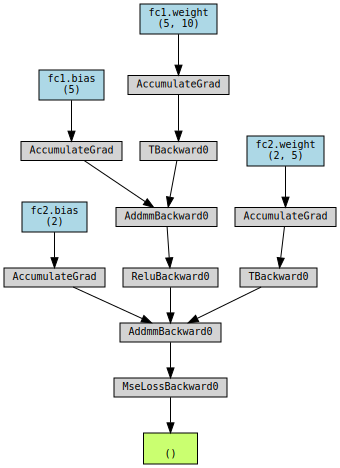

In [42]:
import torch
import torch.nn as nn
from torchviz import make_dot

# Define a simple neural network with two outputs
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(10, 5)
        self.fc2 = nn.Linear(5, 2)  # Two outputs

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create the network and some input data
net = SimpleNet()
x = torch.randn(1, 10)
target = torch.randn(1, 2)  # Dummy target for the loss function

# Perform the forward pass
outputs = net(x)

# Define a loss function
criterion = nn.MSELoss()

# Compute the loss
loss = criterion(outputs, target)

# Perform backpropagation
loss.backward()

# Visualize the computational graph using torchviz
make_dot(loss, params=dict(net.named_parameters()))

In [43]:

# Main loop
collected_frames = 0
total_episodes = 0
start_time = time.time()
num_updates = cfg.loss.num_updates
batch_size = cfg.buffer.batch_size
test_interval = cfg.logger.test_interval
num_test_episodes = cfg.logger.num_test_episodes
frames_per_batch = cfg.collector.frames_per_batch
# pbar = tqdm.tqdm(total=cfg.collector.total_frames)
init_random_frames = cfg.collector.init_random_frames
sampling_start = time.time()
q_losses = torch.zeros(num_updates) #, device=device)

for i, data in enumerate(collector):

        # NOTE: This reshape must be for frame data (maybe)
        data = data.reshape(-1)
        current_frames = data.numel()
        replay_buffer.extend(data)
        collected_frames += current_frames
        greedy_module.step(current_frames)

        # Get the number of episodes
        total_episodes += data["next", "done"].sum()

        # Get and log training rewards and episode lengths
        # Collect the episode rewards and lengths in average over the
        # transitions in the current data batch
        episode_rewards = data["next", "episode_reward"][data["next", "done"]]


        # Warmup phase (due to the continue statement)
        # Additionally This help us to keep a track of the collected_frames
        # after the init_random_frames
        if collected_frames < init_random_frames:
            continue

        # optimization steps
        training_start = time.time()
        for j in range(num_updates):
            sampled_tensordict = replay_buffer.sample(batch_size)
            # TODO: check if the sample is already in the device
            sampled_tensordict = sampled_tensordict #.to(device)

            # Also the loss module will use the current and target model to get the q-values
            loss_td = loss_module(sampled_tensordict)
            q_loss = loss_td["loss"]

            # with loss_module.value_network_params.to_module(loss_module.value_network):
            #     dot = make_dot(q_loss, params=dict(loss_module.value_network.named_parameters()), show_attrs=True, show_saved=True)
            #     dot.render("computational_graph_with_loss", format="png")
            
            optimizer.zero_grad()
            q_loss.backward()

            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)

            optimizer.step()

            # Update the priorities
            if cfg.buffer.prioritized_replay:
                replay_buffer.update_priority(index=sampled_tensordict['index'], priority = sampled_tensordict['td_error'])

            # NOTE: This is only one step (after n-updated steps defined before)
            # the target will update
            target_net_updater.step()
            q_losses[j].copy_(q_loss.detach())
        training_time = time.time() - training_start

        # Get and log evaluation rewards and eval time
        # NOTE: As I'm using only the model and not the model_explore that will deterministic I think
        # with torch.no_grad(): #, set_exploration_type(ExplorationType.DETERMINISTIC):

        #     # NOTE: Check how we are using the frames here because it seems that I am dividing 
        #     # 10 for 50000
        #     prev_test_frame = ((i - 1) * frames_per_batch) // test_interval
        #     cur_test_frame = (i * frames_per_batch) // test_interval
        #     final = current_frames >= collector.total_frames

        #     # compara prev_test_frame < cur_test_frame is the same as current_frames % test_interval == 0
        #     if (i >= 1 and (prev_test_frame < cur_test_frame)) or final:
        #         model.eval()
        #         eval_start = time.time()
        #         test_rewards = eval_model(model, test_env, num_test_episodes)
        #         eval_time = time.time() - eval_start
        #         model.train()
        #         log_info.update(
        #             {
        #                 "eval/reward": test_rewards,
        #                 "eval/eval_time": eval_time,
        #             }
        #         )

        # Log all the information

        # update weights of the inference policy
        # NOTE: Updates the policy weights if the policy of the data 
        # collector and the trained policy live on different devices.
        collector.update_policy_weights_()
        sampling_start = time.time()

collector.shutdown()

Maximum of the model gradients per layer
Maximum of the model gradients per layer
Maximum of the model gradients per layer
Maximum of the model gradients per layer
Maximum of the model gradients per layer
Maximum of the model gradients per layer
Maximum of the model gradients per layer
Maximum of the model gradients per layer
Maximum of the model gradients per layer
tensor(0.0024)
tensor(0.0056)
tensor(0.0090)
tensor(0.0161)
tensor(0.0317)
tensor(0.0813)
tensor(0.0212)
tensor(0.1943)
tensor(0.)
tensor(-1.0666)
Maximum of the model gradients per layer
tensor(0.0024)
tensor(0.0056)
tensor(0.0090)
tensor(0.0161)
tensor(0.0317)
tensor(0.0813)
tensor(0.0212)
tensor(0.1943)
tensor(0.)
tensor(-1.0666)


In [28]:
loss = DQNLoss(value_network=policy, 
               action_space=env.action_spec, 
               delay_value=True) # delay_value=True means we will use a target network
optim = Adam(loss.parameters(), lr=0.02)

# eps: will be used to update the target network as 
# \theta_t = \theta_{t-1} * \epsilon + \theta_t * (1-\epsilon)
# where eps = 1 is hard update
updater = SoftUpdate(loss, eps=0.99)

In [34]:
loss.value_network_params

TensorDictParams(params=TensorDict(
    fields={
        module: TensorDict(
            fields={
                0: TensorDict(
                    fields={
                        module: TensorDict(
                            fields={
                                activation: TensorDict(
                                    fields={
                                    },
                                    batch_size=torch.Size([]),
                                    device=None,
                                    is_shared=False),
                                encoder: TensorDict(
                                    fields={
                                        0: TensorDict(
                                            fields={
                                                bias: Parameter(shape=torch.Size([64]), device=cpu, dtype=torch.float32, is_shared=False),
                                                weight: Parameter(shape=torch.Size([64, 4]), device=cpu, dtype

In [33]:
loss.target_value_network_params

TensorDictParams(params=TensorDict(
    fields={
        module: TensorDict(
            fields={
                0: TensorDict(
                    fields={
                        module: TensorDict(
                            fields={
                                activation: TensorDict(
                                    fields={
                                    },
                                    batch_size=torch.Size([]),
                                    device=None,
                                    is_shared=False),
                                encoder: TensorDict(
                                    fields={
                                        0: TensorDict(
                                            fields={
                                                bias: Parameter(shape=torch.Size([64]), device=cpu, dtype=torch.float32, is_shared=False),
                                                weight: Parameter(shape=torch.Size([64, 4]), device=cpu, dtype

In [80]:
from tensordict import TensorDict
from torchrl.data import SliceSampler
from torchrl.data import LazyMemmapStorage

rb = TensorDictReplayBuffer(
    storage=LazyMemmapStorage(size),
    sampler=SliceSampler(traj_key="episode", num_slices=4),
    batch_size=8,
)
episode = torch.zeros(10, dtype=torch.int)
episode[:3] = 1
episode[3:5] = 2
episode[5:7] = 3
episode[7:] = 4
steps = torch.cat([torch.arange(3), torch.arange(2), torch.arange(2), torch.arange(3)])
obs = torch.randn((3, 4, 5)).expand(10, 3, 4, 5)
data = TensorDict(
    {
        "episode": episode,
        "obs": obs,
        "act": torch.randn((20,)).expand(10, 20),
        "other": torch.randn((20, 50)).expand(10, 20, 50),
        "steps": steps,
    },
    [10],
)
rb.extend(data)
sample = rb.sample()
print("episode are grouped", sample["episode"])
print("steps are successive", sample["steps"])

episode are grouped tensor([3, 3, 4, 4, 2, 2, 1, 1], dtype=torch.int32)
steps are successive tensor([0, 1, 0, 1, 0, 1, 0, 1])


In [82]:
episode

tensor([1, 1, 1, 2, 2, 3, 3, 4, 4, 4], dtype=torch.int32)

In [81]:
rb

TensorDictReplayBuffer(
    storage=LazyMemmapStorage(
        data=TensorDict(
            fields={
                act: MemoryMappedTensor(shape=torch.Size([10, 20]), device=cpu, dtype=torch.float32, is_shared=False),
                episode: MemoryMappedTensor(shape=torch.Size([10]), device=cpu, dtype=torch.int32, is_shared=False),
                index: MemoryMappedTensor(shape=torch.Size([10]), device=cpu, dtype=torch.int64, is_shared=False),
                obs: MemoryMappedTensor(shape=torch.Size([10, 3, 4, 5]), device=cpu, dtype=torch.float32, is_shared=False),
                other: MemoryMappedTensor(shape=torch.Size([10, 20, 50]), device=cpu, dtype=torch.float32, is_shared=False),
                steps: MemoryMappedTensor(shape=torch.Size([10]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([10]),
            device=cpu,
            is_shared=False), 
        shape=torch.Size([10]), 
        len=10, 
        max_size=100), 
    sampler=S

In [234]:
import datetime

current_date = datetime.datetime.now()
date_str = current_date.strftime("%Y_%m_%d-%H_%M_%S")  # Includes date and time
date_str

'2024_07_23-17_34_50'

In [235]:
total_count = 0
total_episodes = 0
t0 = time.time()
for i, data in enumerate(collector):
    # Write data in replay buffer
    rb.extend(data)
    max_length = rb[:]["next", "step_count"].max() # From all the next steps get the max step count
    if len(rb) > init_rand_steps: # wam-up steps
        # Optim loop (we do several optim steps
        # per batch collected for efficiency)
        for _ in range(optim_steps):
            sample = rb.sample(128) # sample a batch of 128 (repetition is allowed)
            # print(sample)
            break
            loss_vals = loss(sample)
            loss_vals["loss"].backward()
            optim.step()
            optim.zero_grad()
            # Update exploration factor
            # NOTE: Why I am updating the exploration factor here? 
            # I'm considering practically that I did 100 (or n) iteractions in the environment time optim_steps
            exploration_module.step(data.numel()) # data.numel() returns the number of elements in the data
            # Update target params each optimisation step
            updater.step()
            if i % 10:
                torchrl_logger.info(f"Max num steps: {max_length}, rb length {len(rb)}")
            total_count += data.numel()
            total_episodes += data["next", "done"].sum() # sum the number of done episodes
    
    if max_length > 200:
        break

t1 = time.time()

torchrl_logger.info(
    f"solved after {total_count} steps, {total_episodes} episodes and in {t1-t0}s."
)

/home/zosov/anaconda3/envs/final-project/lib/python3.11/site-packages/torchrl/data/replay_buffers/replay_buffers.py:585: UserWarning: Got conflicting batch_sizes in constructor (32) and `sample` (128). Refer to the ReplayBuffer documentation for a proper usage of the batch-size arguments. The batch-size provided to the sample method will prevail.
  warnings.warn(
2024-07-23 17:34:53,433 [torchrl][INFO] solved after 0 steps, 0 episodes and in 2.57519268989563s.


In [242]:
sample[0]

TensorDict(
    fields={
        _weight: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
        action: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.int64, is_shared=False),
        action_value: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, is_shared=False),
        chosen_action_value: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        collector: TensorDict(
            fields={
                traj_ids: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([]),
            device=cpu,
            is_shared=False),
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        index: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_sha

In [236]:
sample

TensorDict(
    fields={
        _weight: Tensor(shape=torch.Size([128]), device=cpu, dtype=torch.float32, is_shared=False),
        action: Tensor(shape=torch.Size([128, 2]), device=cpu, dtype=torch.int64, is_shared=False),
        action_value: Tensor(shape=torch.Size([128, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        chosen_action_value: Tensor(shape=torch.Size([128, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        collector: TensorDict(
            fields={
                traj_ids: Tensor(shape=torch.Size([128]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([128]),
            device=cpu,
            is_shared=False),
        done: Tensor(shape=torch.Size([128, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        index: Tensor(shape=torch.Size([128]), device=cpu, dtype=torch.int64, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([128, 1]),

In [8]:
record_env.rollout(max_steps=1000, policy=policy)
video_recorder.dump()

In [5]:
import random

# Generate and print 10 random seeds
random_seeds = [random.randint(0, 1000000) for _ in range(10)]
print(random_seeds)

[118398, 676190, 786456, 171936, 887739, 919409, 711872, 442081, 189061, 117840]
